<h2>
Backtesting a Pairs Trading Strategy
</h2>
<p>
This notebook performs a backtest on a pairs trading strategy based on pairs selection using correlation and cointegration.
The backtest is designed to resemble the actual trading of the strategy. The Python code in this notebook would serve as a model
for the Java code that would be used to trade the strategy (I would never deploy Python in an application that required high
reliability).
</p>
<p>
Pairs trading is a strategy that dates to the 1980s.
</p>
<blockquote>
Pair trading was pioneered by Gerry Bamberger and later led by Nunzio Tartaglia's quantitative group at Morgan Stanley in the 1980s.
</br>
<a href="https://en.wikipedia.org/wiki/Pairs_trade">Pairs Trade in Wikipedia</a>
</blockquote>
<p>
The market-neutral nature of the pairs trading strategy makes it attractive since the strategy is less likely to experience significant drawdowns
during market downturns.
</p>
<p>
There is a fairly sizable literature on pairs trading, consisting of academic articles, blog posts, and a few books. Many of these references suggest that
the strategy can yield attractive returns with lower risk.
</p>
<p>
Unlike many of the references on pairs trading, this notebook was written to evaluate the strategy for actual trading. If the strategy
proved to be attractive, I would have written Java code to trade this strategy. With the possibility of risking my money on this
strategy, I have tried to be careful in the analysis. I compare the pairs strategy to an equivalent portfolio of randomly selected
pairs to determine whether the statistical tests for mean reversion deliver increased returns over the random pairs.
</p>
<p>
A rolling six month in-sample period is used evaluate correlation and cointegration to select pairs. Following the in-sample period there is a trading
period over which the pairs may be traded. The pairs trading results are sensitive to the number of days in the out-of-sample. The pairs trading results
for a one quarter out-of-sample period are almost exactly the same as the results for the random pairs. When the trading period is reduced to half
of a quarter (32 days), the pairs trading results are almost double the results from the random pairs.
</p>
<p>
The source for this notebook can be found on GitHub (https://github.com/IanLKaplan/pairs_trading/blob/master/pairs_trading_backtest.ipynb)
</p>
<p>
This notebook is a sequel to the notebook <i>Exploratory Statistics of Pairs Trading</i>
(https://github.com/IanLKaplan/pairs_trading/blob/master/pairs_trading.ipynb). The previous notebook explores the algorithms for selecting
pairs and the statistics of pairs trading. This statistical exploration provides the foundation for the strategy that is backtested in
this notebook. For a discussion of pairs trading, the algorithms used to select pairs, and the background for the strategy that is
backtested in this notebook, please see the previous notebook.
</p>
<h2>
Pairs Trading Strategy
</h2>
<h3>
Shorting Stocks in Pairs Trading
</h3>
<p>
Pairs trading is a market-neutral long/short strategy where the long and short positions for a pair have approximately equal
dollar values when the position is opened. A profit is realized when there is mean reversion in the spread between
the prices of a pair.
</p>
<p>
This section discusses the mechanics of taking a short position in a stock. A short position in a stock is a margin loan and is more
complicated than a long position.
</p>
<p>
When a stock is "shorted", the stock is borrowed and then immediately sold, realizing cash.  For example, if 100 shares at a current market
price of 10 are shorted, the brokerage account will be credited with 1000 (100 x 10).  At some point in the future, the borrowed stock must be paid
back by buying the stock at the current market price.  A short position is profitable when the market price of the stock goes down.
For example, if the market price of the stock is shorted at 10 and goes down to 6, there is a profit of 4 per share (4 x 100 = 400).
</p>
<p>
Short positions can have an unlimited loss when the stock price goes up.  For example, if the market price of the 10 stock rises to
14 per share, there is a 400 loss on the 100-share purchase. If the stock price doubles to 20 there will be a loss of 10 per share
or 1000 for the short position.
</p>
<p>
Shorting stocks is often considered a risky investment strategy because of the potential for unlimited loss. Pairs
trading is a market-neutral strategy where there is a long position that is approximately equal in dollar value to the short position.
The pairs that are traded are chosen from the same industry sector and are highly correlated and cointegrated. If the market price of
the shorted stock rises, the value of the long member of the pair should rise as well. The profit in the long position will tend
to offset the loss in the short position. This makes the pairs trading strategy less risky than a short-only strategy.
</p>
<p>
When a stock is shorted, the stock is borrowed from the broker. This is treated as a margin loan. The brokerage requires that the customer maintain a
balance with liquid assets of 150 percent of the amount borrowed. This includes the proceeds of the short sale, plus 50 percent.
For example, if 100 shares of a 10-dollar stock are shorted, the account will be credited with 1000. The account must also
have an additional balance of 500. The margin requirement can be met with cash or highly tradable "blue chip" stocks (e.g., S&P 500 stocks).
</p>
<p>
The pairs trading strategy is cash efficient. For example, a long position of 1000 and a short position of 1000 can be opened with
only 500 in cash or highly tradable assets.
</p>
<p>
When the pair spread crosses a threshold, a long-short position is opened in the pair. This threshold is the mean plus or minus
some delta amount. The dollar value of the long and short positions will be approximately equal (they will usually not be exactly
equal because we are trading whole share amounts).  When the spread value crosses the threshold:
</p>
<ol>
<li>
<p>
Open the short position. This will result in cash from the short sale.
</p>
</li>
<li>
<p>
The proceeds from the short sale are used to pay for the long position.  An additional amount of cash may be needed for the long
position.
</p>
</li>
</ol>
<p>
This is summarized in the equations below. The "/" operator is an integer divide operator:
</p>

$$ \text{short shares} = \text{position} / \text{short share price} $$

$$ \text{short cash} = \text{short shares} \times \text{short share price} $$

$$  \text{long shares} = \text{position} / \text{long share price}) $$

$$  \text{long cost} = \text{long shares} \times \text{long share price} $$

<p>
If the cost of the long position is greater than the cash realized from the short position, additional cash will be
allocated for the long position.
</p>
<h4>
Example:
</h4>
<p>
If our trading capital is 100,000 we can open a 200,000 long and 200,000 short position, given a 50 percent margin.
Ideally the margin funds could be allocated to an asset like a bond ETF which pays a monthly dividend.
</p>
<p>
If we trade 100 pairs, then each pair is allocated 1,600 for the long and short positions.
</p>
<p>
Stock A (the long position) is 63 per share and stock B (the short position) is 54 a share.  We open the short position first
to obtain the cash for the long position. The division operations are integer divisions.
</p>

$$ \text{short position} = floor(1600 / 54) = \text{29 shares} \times 54 =  1566 $$

$$ \text{long position} = round(1600 / 63 ) = \text{25 shares} \times 63 = 1575 = \text{1566 short} + \text{9 cash} $$

<p>
Interactive Brokers charges a yearly fee for short positions is 0.25 percent or 0.25/360 percent per day that the position is held.
This is small enough that the short-interest cost can be ignored.
</p>
<p>
The pairs trading strategy will have a portfolio of short and long positions which are opened and closed as the pair spread moves.
At any time, the aggregate value of the short positions and the long positions, plus margin cash, must be within the margin
requirements. If there is a liquidity deficit relative to the margin, IB will liquidate the deficit amount times 4 (ouch!)
</p>
<p>
When the short position is opened there must be a margin of at least 50 percent. Interactive brokers marks to market in real-time.
The SEC regulation T requires that there be a margin of at least 25% for open short positions.
</p>
<h4>
Interactive Brokers Margin reference
</h4>
<ul>
<li>
<a href="https://www.interactivebrokers.com/en/general/education/pdfnotes/WN-UnderstandingMargin.php">Understanding Margin Webinar Notes</a>
</li>
</ul>
<h3>
Stock Price Data Issues
</h3>
<p>
The backtest in this notebook uses the daily close price for the stocks. If a large number of stocks are traded (i.e., 100 stocks)
a Java trading application would use the intraday prices. The intraday prices will generally not be the same as
the close price. The purpose of the backtest in this notebook is to provide an indication of the profitability and risk of the
pairs trading strategy, so this difference is acceptable.
</p>
<h3>
In-sample and out-of-sample time periods
</h3>
<p>
The pairs trading set is constructed by looking back over the past in-sample period. The out-of-sample period is the trading period.
</p>
<ul>
<li>
<p>
In-sample period: six months (126 trading days)
</p>
</li>
<li>
<p>
Out-of-sample (trading) period: three months (31 trading days). A 31-day period should be long enough to capture mean reversion
while still maintaining the statistical characteristics of the in-sample period.
By using a relatively short out-of-sample period risk of holding pairs is reduced and the statistics for pairs selection can
be calculated after the out-of-sample period.
</p>
</li>
</ul>
<h3>
Data Snooping
</h3>
<p>
Data snooping takes place when the performance of a strategy is observed and used to adjust strategy parameters. Future information
that would not have been available over the strategy back-test can result in differences between strategy backtest results and actual
trading results.
</p>
<p>
The length of the out-of-sample trading period was adjusted from one quarter to a half quarter on the basis of observed pairs trading
results. The theoretical justification for this is that a shorter out-of-sample period is more likely to statistically resemble the
in-sample period used for pairs selection.
</p>
<p>
Observations of the pairs performance was also used to remove the limitation that pairs have unique stocks.
</p>
<p>
The adjustments to the strategy are broad and data snooping is not obviously an issue in these cases.
</p>
<h3>
Strategy
</h3>
<p>
Get pairs for each S&P 500 industrial sectors
</p>
<p>
For each 126 day in-sample window (moving forward every 63-days):
</p>
<ol>
<li>
Select the pairs with close price series correlation greater than or equal to 0.75
</li>
<li>
Select the high correlation pairs that show Granger cointegration
</li>
<li>
Sort the pair spread time series by volatility (high to low volatility). Higher volatility (standard deviation) pairs
are more likely to be profitable.
</li>
<li>
Select the top N pairs from the sorted pair list
</li>
</ol>
<h4>
Out-of-sample trading period
</h4>
<p>
The pairs trading backtest is intended to be as close to actual trading as possible in order to understand whether this strategy is worth
pursuing for actual trading.
</p>
<p>
At the start date of the backtest, the total cash available is N dollars (e.g., 100,000). With a required margin of 50 percent,
this would allow us to have a position of 2N for the long and short positions (e.g., for 100,000 cash, long and short positions
of 200,000 each).
</p>
<p>
Positions are opened for whole share values.
</p>
<p>
At the end of each out-of-sample trading period, any open positions will closed.
</p>
<p>
For each pair (in the N pair set) in the out-of-sample trading period:
</p>
<ol>
<li>
<p>
Calculate the current spread value S from the current pair close prices (stocks A and B).
</p>

$ S_t = A{_t} - \text{intercept} - \beta B{_t} $

</li>
<li>
The
$ \Delta $
value is a multiplier for the standard deviation
$ \sigma $
If
$ spread_t >= \mu + \Delta \sigma $
then open a short position in
$ A $
and a long position in
$ \beta B $
</li>
<li>
If
$ spread_t <= \mu + \Delta \sigma$
then open a long position in
$ A $
and a short position in
$ B $
</li>
<li>
If there is an open pair position that has a spread that crosses the mean, the positions will be closed. The profit and
loss amount will be updated.
</li>
</ol>


In [6]:
%pip install statsmodels iteration-utilities yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 35.6 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-py3-none-any.whl size=138891 sha256=f0c20b1c433caf0ebe89c2a6cb7c02a5ee7f47c2114a652fc588f913966f139c
  Stored in directory: /home/codespace/.cache/pip/wheels/a6/5e/0f/8319805c4115320e0d3e8fb5799b114a2e4c4a3d6c7e523b06
Successfully built peewee


In [23]:

#
# To generate a python file from the notebook use jupytext:
# pip install jupytext --upgrade
# jupytext --to py pairs_trading_backtest.ipynb
#

import ast
import faulthandler
import os
import random
from abc import abstractmethod
from datetime import datetime, timedelta
from enum import Enum
from typing import List, Tuple, Dict, Set

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from iteration_utilities import deepflatten
from statsmodels.regression.linear_model import RegressionResults
from statsmodels.tsa.stattools import adfuller

#
# Local libraries
#
from pairs.pairs import get_pairs
from plot_ts.plot_time_series import plot_two_ts
from read_market_data.MarketData import MarketData, read_s_and_p_stock_info, extract_sectors
from s_and_p_filter import s_and_p_directory, s_and_p_stock_file
from utils import find_date_index
from utils.find_date_index import findDateIndex

# Apply the default theme
sns.set_theme()

# Set the random seed for generating a random set of pairs.
random_seed = 7723
random.seed(random_seed)

s_and_p_file = s_and_p_directory + os.path.sep + s_and_p_stock_file

#start_date_str = '2007-01-03'
start_date_str = '2020-01-03'
start_date: datetime = datetime.fromisoformat(start_date_str)

trading_days = 252
half_year = int(trading_days / 2)
quarter = int(trading_days / 4)

stock_info_df = read_s_and_p_stock_info(s_and_p_file)
stock_l: list = list(set(stock_info_df['Symbol']))
market_data = MarketData(start_date=start_date)

# Get close prices for the S&P 500 list and SPY
stock_l.append('SPY')
stock_l.sort()
close_prices_df = market_data.get_close_data(stock_l)

# Get the SPY close data
spy_close_df = pd.DataFrame(close_prices_df['SPY'])
spy_close_df.columns = ['SPY']
close_prices_df = close_prices_df.drop(columns=['SPY'])

final_stock_list = list(close_prices_df.columns)

# Make sure that SPY is not on the pairs set
assert not 'SPY' in set(final_stock_list)

mask = stock_info_df['Symbol'].isin(final_stock_list)
# Some stocks were listed on the stock exchange later than start_date. In this case, the stock will not
# be returned by MarketData.get_close_data(). final_stock_info has the Symbol, Name, Sector for the
# set of stocks that it was possible to obtain close prices for the date range.
final_stock_info_df = stock_info_df[mask]

sectors = extract_sectors(final_stock_info_df)

pairs_list = get_pairs(sectors)

class CointData:

    def __init__(self, stock_a: str, stock_b: str, weight: float, intercept: float):
        self.stock_a: str = stock_a
        self.stock_b: str = stock_b
        self.key = f'{self.stock_a}:{self.stock_b}'
        self.weight: float = weight
        self.intercept: float = intercept
        self.stddev: float = 0.0

    def __str__(self):
        s = f'{self.key} weight: {self.weight} intercept: {self.intercept} stddev: {self.stddev}'
        return s


class PairStatisticsBase:
    def __init__(self) -> None:
        self.decimals = 2

    def pair_regression(self, pair: Tuple, close_prices: pd.DataFrame) -> Tuple[Tuple[str, str], float, float, RegressionResults]:
        stock_A: str = pair[0]
        stock_B: str = pair[1]
        close_a = close_prices[stock_A]
        close_b = close_prices[stock_B]
        close_b_const = sm.add_constant(close_b)
        # x = I + b * A
        result_ab = sm.OLS(close_a, close_b_const).fit()
        close_a_const = sm.add_constant(close_a)
        # x = I + b * B
        result_ba = sm.OLS(close_b, close_a_const).fit()
        slope_ab = result_ab.params[stock_B]
        slope_ba = result_ba.params[stock_A]
        result = result_ab
        slope = slope_ab
        if slope_ab < slope_ba:
            t = stock_A
            stock_A = stock_B
            stock_B = t
            result = result_ba
            slope = slope_ba
        slope: float = round(slope, self.decimals)
        intercept: float = round(result.params['const'], self.decimals)
        ordered_pair: Tuple[str,str] = (stock_A, stock_B)
        return ordered_pair, slope, intercept, result


class InSamplePairBase:
    def __init__(self, corr_cutoff: float, num_pairs: int) -> None:
        self.corr_cutoff = corr_cutoff
        self.num_pairs = num_pairs

    @classmethod
    @abstractmethod
    def get_in_sample_pairs(self, pairs_list: List[Tuple], close_prices: pd.DataFrame) -> List[CointData]:
        pass

class RandomInSamplePairs(InSamplePairBase):
    def __init__(self, corr_cutoff: float, num_pairs: int) -> None:
        super().__init__(corr_cutoff, num_pairs)

    def unique_random_index(self, set_len: int, set_range: int) -> List[int]:
        index_set: Set[int] = set()
        while len(index_set) < set_len:
            rand_ix = random.randint(0, set_range)
            if rand_ix not in index_set:
                index_set.add(rand_ix)
        return list(index_set)

    def get_in_sample_pairs(self, pairs_list: List[Tuple], close_prices: pd.DataFrame) -> List[CointData]:
        pair_stats_obj = PairStatisticsBase()
        random_index: List[int] = self.unique_random_index(self.num_pairs, len(pairs_list) - 1)
        # random_pair_list = pairs_list[ random_index ]
        random_pair_list: List[Tuple] = list(map(lambda ix: pairs_list[ix], random_index))
        coint_list: List[CointData] = list()
        for pair in random_pair_list:
            pair_syms, slope, intercept, result = pair_stats_obj.pair_regression(pair, close_prices=close_prices_df)
            coint_data = CointData(stock_a=pair_syms[0], stock_b=pair_syms[1], weight=slope, intercept=intercept)
            coint_list.append(coint_data)
        return coint_list


class PairStatistics(PairStatisticsBase):

    def __init__(self) -> None:
        super().__init__()
        pass

    def pair_correlation(self, pair: Tuple, close_prices: pd.DataFrame) -> float:
        stock_list = close_prices.columns
        """
        :param pair: the pair is a Tuple like  ('ALB', 'APD', 'materials') So pair[0] is 'ALB' and pair[1] is 'APD'
        :return: the correlation for the pair in the close price period
        """
        stock_A: str = pair[0]
        stock_B: str = pair[1]
        correlation: float = -2.0  # bad correlation value
        if stock_A in stock_list and stock_B in stock_list:
            data_a = close_prices[stock_A]
            data_b = close_prices[stock_B]
            c = np.corrcoef(data_a, data_b)
            correlation = round(c[0, 1], 2)
        return correlation

    def check_coint(self, coint_stat: float, critical_vals: dict) -> bool:
        """
        :param coint_stat: the ADF statistic
        :param critical_vals: a dictionary defining the ADF intervals {'1%': -3.49, '5%': -2.89, '10%': -2.58}. The
                              dictionary values may be either positive or negative.
        :return: if the adf_stat is in the critical value range, return True, False otherwise
        """
        cointegrated = False
        abs_coint_stat = abs(coint_stat)
        for key, value in critical_vals.items():
            abs_value = abs(value)
            if abs_coint_stat > abs_value:
                cointegrated = True
                break
        return cointegrated

    def engle_granger_coint(self, pair: Tuple, close_prices: pd.DataFrame) -> CointData:
        stock_list = close_prices.columns
        coint_data = None
        stock_A = pair[0]
        stock_B = pair[1]
        if stock_A in stock_list and stock_B in stock_list:
            pair_syms, slope, intercept, result = self.pair_regression(pair, close_prices=close_prices)
            # A hack that attempts to get rid of outlier pairs. The values for the slope and intercept cutoffs
            # were arrived at by looking at the distributions of the data. Still, it's a bit arbitrary.
            if slope <= 6 and abs(intercept) <= 100:
                residuals = result.resid
                adf_result = adfuller(residuals)
                adf_stat = round(adf_result[0], self.decimals)
                critical_vals = adf_result[4]
                cointegrated = self.check_coint(adf_stat, critical_vals)
                if cointegrated:
                    coint_data = CointData(stock_a=pair_syms[0], stock_b=pair_syms[1], weight=slope, intercept=intercept)
        return coint_data

    def add_spread_stats(self, coint_data_list: List[CointData], close_prices: pd.DataFrame) -> None:
        """
        Add the spread standard deviation to the CointData object
        :param coint_data_list:
        :return:
        """
        for coint_pair in coint_data_list:
            stock_a = coint_pair.stock_a
            stock_b = coint_pair.stock_b
            close_a = close_prices[stock_a]
            close_b = close_prices[stock_b]
            weight = coint_pair.weight
            spread = close_a - coint_pair.intercept - weight * close_b
            coint_pair.stddev = np.std(spread)


class InSamplePairs(InSamplePairBase):

    def __init__(self, corr_cutoff: float, num_pairs: int) -> None:
        super().__init__(corr_cutoff=corr_cutoff, num_pairs=num_pairs)
        self.pair_stats_obj = PairStatistics()

    def select_pairs(self, pairs_list: List[Tuple], in_sample_close: pd.DataFrame) -> List[CointData]:
        """
        Select pairs with high correlation and cointegratoin
        :param pairs_list: a list of pairs
        :return: a list of CointData for pairs that have a correlation greater than self.corr_cutoff and
        are cointegrated.
        """
        coint_list: List = list()
        for pair in pairs_list:
            pair_cor = self.pair_stats_obj.pair_correlation(pair, close_prices=in_sample_close)
            if pair_cor >= self.corr_cutoff:
                coint_data = self.pair_stats_obj.engle_granger_coint(pair, close_prices=in_sample_close)
                if coint_data is not None:
                    coint_list.append(coint_data)
        return coint_list


    def get_in_sample_pairs(self, pairs_list: List[Tuple], close_prices: pd.DataFrame) -> List[CointData]:
        coint_data_list: List[CointData] = self.select_pairs(pairs_list, in_sample_close=close_prices)
        self.pair_stats_obj.add_spread_stats(coint_data_list, close_prices=close_prices)
        # Sort by declining standard deviation value
        coint_data_list.sort(key=lambda elem: elem.stddev, reverse=True)
        truncated_list = coint_data_list[0:self.num_pairs]
        return truncated_list


def normalize_df(data_df: pd.DataFrame) -> pd.DataFrame:
    min_s = data_df.min()
    max_s = data_df.max()
    norm_df = (data_df - min_s) / (max_s - min_s)
    return norm_df


def plot_stationary_ts(stationary_df: pd.DataFrame, plus_delta: float, minus_delta: float, title: str) -> None:
    stationary_df.plot(grid=True, title=title, figsize=(10, 6))
    stat_mean = stationary_df.mean()[0]
    plt.axhline(y=stat_mean, color='black', linewidth=2)
    plt.axhline(y=stat_mean + plus_delta, color='red', linewidth=1, linestyle='--')
    plt.axhline(y=stat_mean - minus_delta, color='green', linewidth=1, linestyle='--')
    plt.show()


def plot_pair_data(close_df: pd.DataFrame, pair: CointData, title_prefix: str) -> None:
    stock_a_df: pd.DataFrame = pd.DataFrame(close_df[pair.stock_a])
    stock_b_df: pd.DataFrame = pd.DataFrame(close_df[pair.stock_b])
    stock_a_norm_df = normalize_df(stock_a_df)
    stock_b_norm_df = normalize_df(stock_b_df)
    plot_two_ts(data_a=stock_a_norm_df, data_b=stock_b_norm_df,
                title=f'{title_prefix} normalized {pair.stock_a},{pair.stock_b}',
                x_label='date', y_label='Normalized Price')
    spread_df = pd.DataFrame(stock_a_df.values - pair.intercept - pair.weight * stock_b_df.values)
    spread_df.index = close_df.index
    plot_stationary_ts(stationary_df=spread_df, plus_delta=pair.stddev, minus_delta=pair.stddev,
                       title=f'{title_prefix} spread for {pair.stock_a} and {pair.stock_b}')


corr_cutoff = 0.75
num_pairs = 100

in_sample_start = find_date_index.findDateIndex(close_prices_df.index, start_date)
in_sample_end = in_sample_start + half_year
in_sample_df = close_prices_df.iloc[in_sample_start:in_sample_end]
pairs_stats_obj = PairStatistics()
period_backtest = InSamplePairs(corr_cutoff=corr_cutoff, num_pairs=num_pairs)
coint_list = period_backtest.get_in_sample_pairs(pairs_list, close_prices=in_sample_df)




1 Failed download:
['CDAY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['CDAY']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['CTXS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['ABC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['DISH']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['ABMD']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['FBHS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['NLOK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['PEAK']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['DRE']: YFTzMissingE

<h2>
Filtering Pairs
</h2>
<p>
From the universe of S&P 500 industry sector stock pairs, pairs are first selected for high correlation and then for
cointegration using the Engle-Granger test (linear regression and the ADF test).
</p>
<p>
The distribution of the standard deviation of the pairs spread is shown below.
</p>

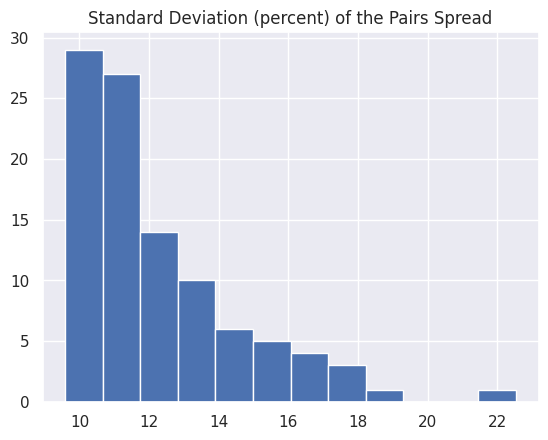

In [25]:

spead_stddev = np.array(list(elem.stddev for elem in coint_list))
plt.hist(spead_stddev, bins='auto')
plt.title('Standard Deviation (percent) of the Pairs Spread')
plt.show()

out_of_sample_start = in_sample_end
out_of_sample_end = out_of_sample_start + quarter
out_of_sample_df = close_prices_df.iloc[out_of_sample_start:out_of_sample_end]


<h2>
Unstable Statistics
</h2>
<p>
In the pairs trading literature, a central concept is that the statistics that are calculated for the in-sample period are stable
(stationary) and will persist in the out-of-sample trading period. The previous notebook, <i>Exploratory Statistics of Pairs Trading</i>,
looks at the stability of correlation and cointegration between adjacent periods. As it turns out, high correlation is consistent between adjacent periods
only about 50 percent of the time. Cointegration is persistent between adjacent periods even less, only about 40 percent of the time.
</p>
<p>
Pairs trading assumes that the spread time series is "stationary", and that it has a constant mean and standard deviation. Unfortunately, this
is not necessarily true, even for spread time series that are mean reverting in the in-sample and out-of-sample period.
</p>
<p>
The plots below show the normalized time series for a pair and the spread time series. The plots show the mean as a thick horizontal line.
The in-sample mean is near zero. The out-of-sample mean is far from zero. In both of the plots of the spread time series,
the in-sample deviation is shown in the dotted line. As it turns out, the out-of-sample standard deviation is around twice the in-sample
standard deviation.
</p>

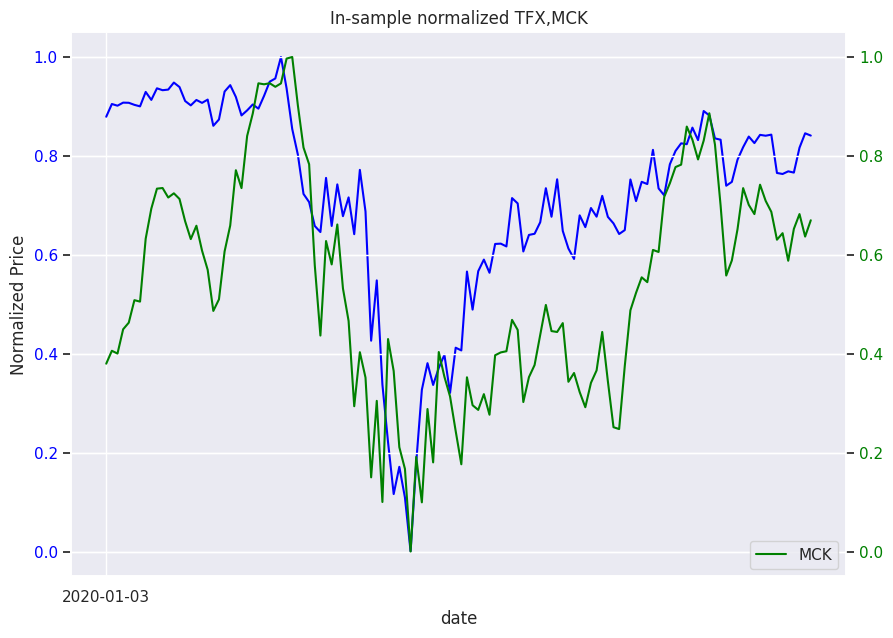

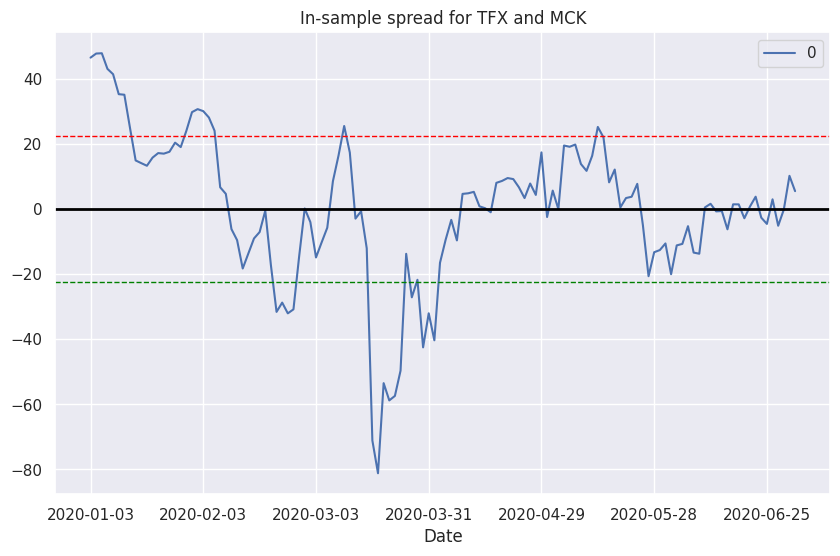

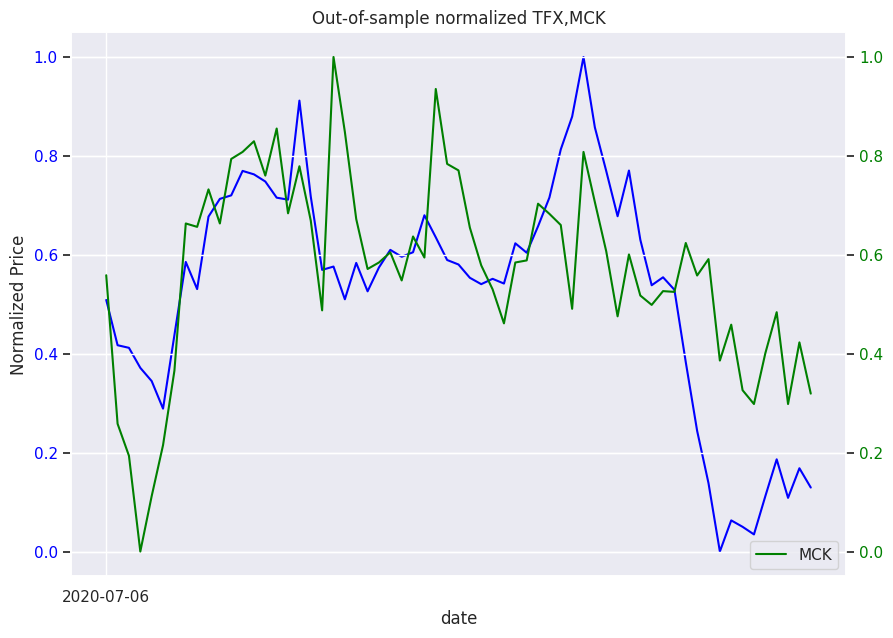

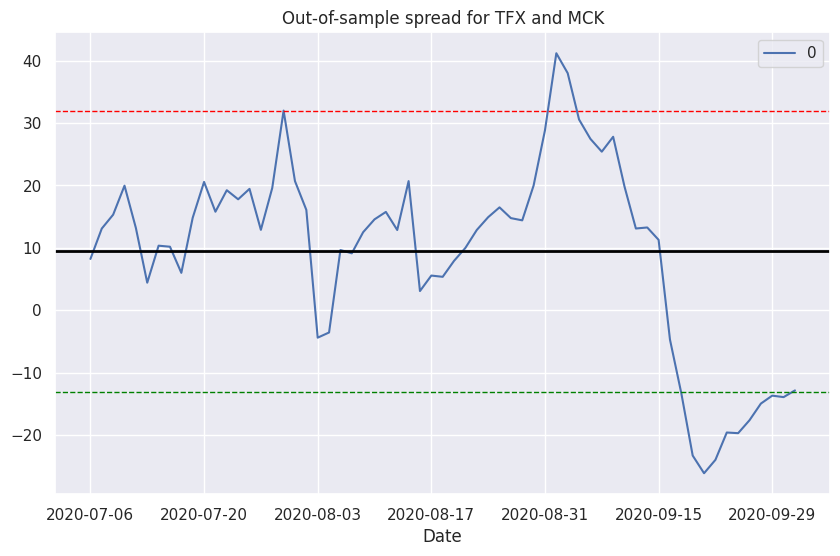

In [26]:


pair = coint_list[0]
plot_pair_data(in_sample_df, pair, 'In-sample')

plot_pair_data(out_of_sample_df, pair, 'Out-of-sample')


<h2>
Bollinger Band
</h2>
<p>
The pairs trading algorithm opens pairs positions when the spread is above or below the mean by some amount. In the pairs
trading literature, the spread is a stationary time series, with a mean that is relatively constant between the in-sample
and out-of-sample time periods. As the above example shows, in practice, the mean is often not constant between the in-sample
and out-of-sample periods.
</p>
<p>
The mean is constantly changing, so a rolling mean is calculated on a look-back window. A rolling standard deviation is also
calculated on the same lookback window. When the spread is above or below the rolling mean by some amount, a pairs position is
opened. When there is an open pair position and the spread crosses the rolling mean, the position is closed.
</p>
<p>
This is a Bollinger Band. In the pairs trading literature, a number of articles use Bollinger Bands for pairs trading.  See
<a href="http://jonathankinlay.com/2019/02/pairs-trading-in-practice/"><i>Pairs Trading in Practice</i></a> by Jonathan
Kinlay, Feb 18, 2019.
</p>
<p>
The common Bollinger band limit is two standard deviations. This seems to work well for pairs trading. I have tried both one and two
standard deviation bands. The two standard deviation band results in higher portfolio profits and less trading.
</p>


In [27]:

def plot_mean_spread(pair: CointData, close_prices_df: pd.DataFrame, start_ix: int, data_window: int,
                     mean_window: int, stddev_delta: float, title: str ) -> None:
    """
    Starting at start_ix calculate the spread from start_ix to start_ix + data_window.
    Calculate the rolling mean from start_ix

    :param close_prices_df:
    :param start_ix:
    :param data_window:
    :param mean_window:
    :return:
    """
    end_ix = start_ix + mean_window + data_window
    index = close_prices_df.index[start_ix:end_ix]
    index_from_window = index[window:]
    stock_a_df = close_prices_df[pair.stock_a].iloc[start_ix:end_ix]
    stock_b_df = close_prices_df[pair.stock_b].iloc[start_ix:end_ix]
    spread_df = pd.DataFrame(stock_a_df.values - pair.intercept - pair.weight * stock_b_df.values)
    spread_df.columns = ['Spread']
    spread_mean_df = spread_df.rolling(mean_window).mean().iloc[mean_window:]
    spread_mean_df.columns = ['Mean']
    spread_mean_df.index = index_from_window
    spread_stddev_df = stddev_delta * spread_df.rolling(mean_window).std().iloc[mean_window:]
    mean_plus_stddev = pd.DataFrame(spread_mean_df.values + spread_stddev_df.values)
    mean_plus_stddev.index = index_from_window
    mean_plus_stddev.columns = [f'Mean + {stddev_delta} x stddev']
    mean_minus_stddev = pd.DataFrame(spread_mean_df.values - spread_stddev_df.values)
    mean_minus_stddev.index = index_from_window
    mean_minus_stddev.columns = [f'Mean - {stddev_delta} x stddev']
    spread_df: pd.DataFrame = spread_df.iloc[window:]
    spread_df.index = index_from_window
    spread_df.columns = ['Spread']
    data_df = pd.concat([spread_df, spread_mean_df, mean_plus_stddev, mean_minus_stddev], axis=1)
    data_df.plot(grid=True, title=title, figsize=(10, 6))


<p>
The plots below show the spreads for the in-sample and out-of-sample pairs, along with Bolinger Bands using the running mean and standard deviation.
</p>

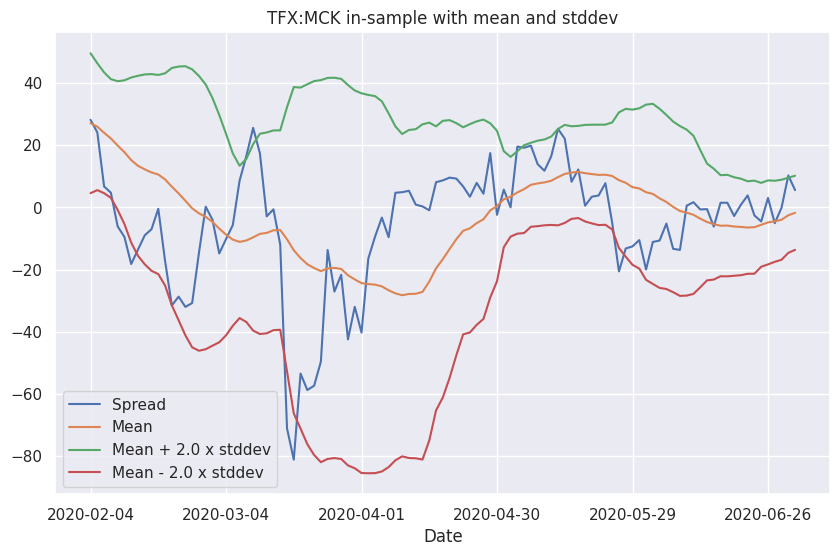

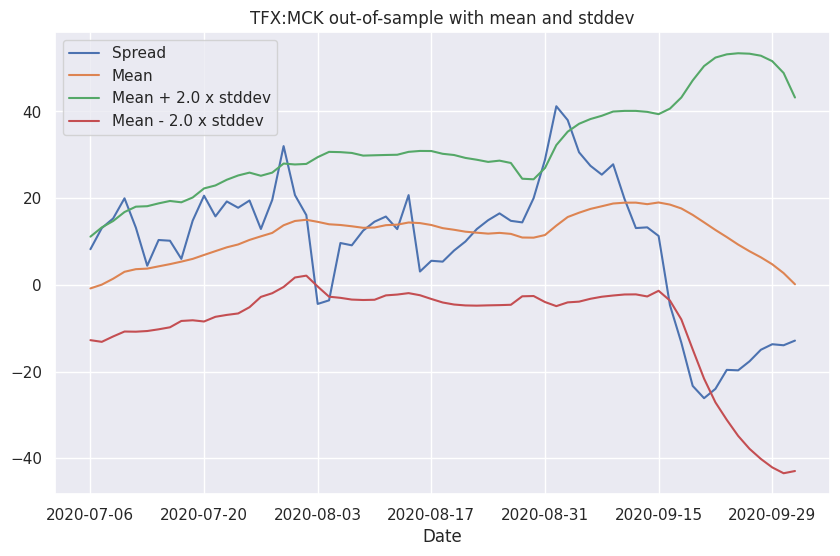

In [28]:


delta = 2.0

window = trading_days // 12
window_in_of_sample_start = in_sample_start
plot_mean_spread(pair=pair, close_prices_df=close_prices_df, start_ix=window_in_of_sample_start,
                 data_window=half_year - window, mean_window=window, stddev_delta=delta,
                 title=f'{pair.key} in-sample with mean and stddev')

window_out_of_sample_start = in_sample_end - window
plot_mean_spread(pair=pair, close_prices_df=close_prices_df, start_ix=window_out_of_sample_start,
                 data_window=quarter, mean_window=window, stddev_delta=delta,
                 title=f'{pair.key} out-of-sample with mean and stddev')

plt.show()


In [29]:


from utils.convert_date import convert_date


class OpenPosition(Enum):
    NOT_OPEN = 1
    SHORT_A_LONG_B = 2
    LONG_A_SHORT_B = 3
    SHARE_PRICE_OUT_OF_BUDGET = 4
    OUT_OF_MARGIN = 5


class DayTransactions:

    def __init__(self,
                 day_date: datetime,
                 positive_trades: int,
                 negative_trades: int,
                 days_open: List[int],
                 day_profit: float,
                 day_return: float,
                 num_open_positions: int,
                 margin: int):
        """
        :param day_date: the date for the day
        :param positive_trades: number of pair transactions that were profitable
        :param negative_trades: number of pair transactions that were at a loss
        :param days_open: a list of the number of days that the pair positions were open. len(days_open) = num pairs
        :param day_profit: the total profit (or loss)
        :param day_return: the total return
        :param margin: the open margin for the day, calculated from the open positions.
        """
        self.day_date = day_date
        self.positive_trades = positive_trades
        self.negative_trades = negative_trades
        self.days_open = days_open
        self.day_profit = day_profit
        self.day_return = day_return
        self.num_open_positions = num_open_positions
        self.margin = margin

    def __str__(self):
        format = '%Y-%m-%d'
        s1 = f'date: {self.day_date.strftime(format)} win trades: {self.positive_trades} loss trades: {self.negative_trades} profit: {round(self.day_profit, 2)}'
        s2 = f'return: {round(self.day_return, 4)} margin: {self.margin}'
        return s1 + s2


class PairTransaction:
    """
    A container for the information on a pair transaction.
    """

    def __init__(self,
                 pair: str,
                 close_date: datetime,
                 days_open: int,
                 total_profit: float,
                 pair_return: float,
                 margin: int) -> None:
        """
        :param pair the pair ticker symbols concatenated as a string. Example 'HUM:VRTX'
        :param close_date: the date the transaction was closed
        :param days_open the number of days that the pair position was open
        :param total_profit the profit (or loss) from closing the pair position
        :param pair_return: the return of the long-short position
        :param margin: the margin cash required while the short position was open
        """
        self.pair = pair
        self.close_date = close_date
        self.days_open = days_open
        self.total_profit = total_profit
        self.pair_return = pair_return
        self.margin = margin

    def __str__(self):
        format = '%Y-%m-%d'
        s1 = f'{self.pair} days open: {self.days_open}, close date: {self.close_date.strftime(format)}, '
        s2 = f'profit: {self.total_profit}, return: {self.pair_return}, margin: {self.margin}'
        s = s1 + s2
        return s


class Position:
    initial_margin_percent = 0.50

    def __init__(self,
                 pair_str: str,
                 position_type: OpenPosition,
                 open_date: datetime,
                 price_a: float,
                 price_b: float,
                 day_index: int,
                 budget: int):
        """
        spread = stock_A - Weight * Stock_B
        :param pair_str a string representation of the pair 'FOO:BAR'
        :param position_type: an enumeration value indicating the position type
        :param open_date the date the position was opened
        :param price_a: the current price of stock A
        :param price_b: the current price of stock B
        :param day_index: the index in the close price series for the current day. Used to calculate days open
        :param budget: the cash that can be allocated for the long/short position

        """
        self.pair_str = pair_str
        self.position_type = position_type
        self.open_date = open_date
        self.price_a = price_a  # share price for stock A at time of position open
        self.price_b = price_b  # share price for stock B at time of position open
        self.day_index = day_index
        self.shares_a = 0
        self.shares_b = 0
        self.margin: int = 0  # The margin amount above the value of the long position
        if position_type == OpenPosition.SHORT_A_LONG_B:
            # Short A
            self.shares_a = budget // self.price_a
            cost_a = round(self.shares_a * self.price_a, 0)
            # Cash is the amount from the short of A plus any cash left over
            cash = cost_a + (budget - cost_a)
            # An approximately equal amount of cash is used to for the long position.
            self.shares_b = cash // self.price_b
            cost_b = round(self.shares_b * self.price_b, 0)
            # The required margin is 150% of the short position. The long position can be used for the margin
            required_margin = round(cost_a * (1 + self.initial_margin_percent), 0)
            self.margin = max(required_margin - cost_b, 0)
        elif position_type == OpenPosition.LONG_A_SHORT_B:
            # Short weight * B
            self.shares_b = budget // self.price_b
            cost_b = round(self.shares_b * self.price_b, 0)
            cash = cost_b + (budget - cost_b)
            # Long A
            self.shares_a = cash // self.price_a
            cost_a = round(self.shares_a * self.price_a, 0)
            required_margin = round(cost_b * (1 + self.initial_margin_percent), 0)
            self.margin = max(required_margin - cost_a, 0)

    def __str__(self) -> str:
        s = f'{self.pair_str} open date: {self.open_date} price: {self.price_a}:{self.price_b} shares: {self.shares_a}:{self.shares_b} margin: {self.margin}'
        return s


class OutOfSampleBacktest:

    def __init__(self, holdings: int) -> None:
        self.holdings = holdings

    def backtest_pairs_list(self,
                            close_prices_df: pd.DataFrame,
                            pair_list: List[CointData],
                            start_date: datetime,
                            back_window: int,
                            trading_period: int,
                            delta: float):
        """
        Backtest a list of pairs over a single out-of-sample trading period.

        :param close_prices_df: the close prices for the stock data set
        :param pair_list: the list of pairs to be back tested
        :param start_date: the start date where the test begins. This date must be the date that followed the
                           in-sample period used to select the pairs
        :param back_window: a window backward used for the running mean and standard deviation
        :param trading_period: the width of the trading period
        :param delta: the multiplier for the standard deviation used in the Bollinger band
        :return:
        """
        date_index = close_prices_df.index
        start_ix = find_date_index.findDateIndex(date_index, start_date)
        assert start_ix > 0
        assert (start_ix - window) >= 0


class DailyStats:
    def __init__(self, key: str, mean: float, stddev: float, day_spread: float, stock_a: float, stock_b: float):
        self.key = key
        self.mean = mean
        self.stddev = stddev
        self.day_spread = day_spread
        self.stock_a = stock_a
        self.stock_b = stock_b

    def __str__(self) -> str:
        s = f'{self.key} price: {self.stock_a}:{self.stock_b} spread: {self.day_spread} mean: {self.mean} stddev: {self.stddev}'
        return s

class HistoricalBacktest:
    reg_T_margin_percent = 0.25

    #             in_sample_pairs_obj = InSamplePairs(corr_cutoff=self.corr_cutoff, num_pairs=self.num_pairs)

    def __init__(self,
                 pairs_list: List[Tuple],
                 initial_holdings: int,
                 num_pairs: int,
                 in_sample_days: int,
                 out_of_sample_days: int,
                 back_window: int,
                 delta: float,
                 day_limit: int,
                 in_sample_pairs_obj: InSamplePairBase ) -> None:
        """
        Back test pairs trading through a historical period
        :param pairs_list: the list of possible pairs from the S&P 500. Each Tuple consists of the pair stock
                           symbols and the industry sector. For example: ('AAPL', 'ACN', 'information-technology')
        :param initial_holdings: The trading capital. Because this is a long-short strategy, this is the amount of cash
                         that can be used for the required margin.
        :param num_pairs: the total number of pairs to be traded
        :param in_sample_days: the number of days in the in-sample period used to select pairs
        :param out_of_sample_days: the number of days in th out-of-sample trading period
        :param back_window: the look-back window used to calculate the running mean and standard deviation
        :param delta: The offset from the mean for opening positions
        """
        assert back_window < in_sample_days
        self.pairs_list = pairs_list
        self.initial_holdings = initial_holdings
        self.num_pairs = num_pairs
        self.in_sample_days = in_sample_days
        self.out_of_sample_days = out_of_sample_days
        self.back_window = back_window
        self.delta = delta
        self.day_limit = day_limit
        self.in_sample_pairs_obj = in_sample_pairs_obj

    def spread_stats(self, pair: CointData,
                     back_win_stock_a: pd.DataFrame,
                     back_win_stock_b: pd.DataFrame,
                     stock_a_day: float,
                     stock_b_day: float) -> DailyStats:
        intercept: float = pair.intercept
        weight: float = pair.weight

        back_spread_df = pd.DataFrame(
            back_win_stock_a.values - pair.intercept - pair.weight * back_win_stock_b.values)
        mean = np.mean(back_spread_df.values).round(2)
        stddev = np.std(back_spread_df.values).round(2)
        day_spread = stock_a_day - pair.intercept - pair.weight * stock_b_day
        stats = DailyStats(key=pair.key, mean=mean, stddev=stddev, day_spread=day_spread, stock_a=stock_a_day,
                           stock_b=stock_b_day)
        return stats


    def update_margin(self, position: Position, day_stats: DailyStats, current_date: datetime) -> None:
        """
        Interactive Brokers adjusts the margin as the price changes. This means that as the price
        changes, additional margin may be required. This function calculates the maximum margin amount
        for the position.
        :param day_stats: the current statistics for the day
        :param current_date: the current date
        :return: None
        """
        assert position is not None
        # Short A, Long B
        short_shares = position.shares_a
        long_shares = position.shares_b
        short_price = day_stats.stock_a
        long_price = day_stats.stock_b
        if position.position_type == OpenPosition.LONG_A_SHORT_B:
            # Short B, Long A
            short_shares = position.shares_b
            long_shares = position.shares_a
            short_price = day_stats.stock_b
            long_price = day_stats.stock_a
        short_position = short_shares * short_price
        long_position = long_shares * long_price
        required_margin = round(short_position * (1 + self.reg_T_margin_percent), 2)
        required_cash = max(required_margin - long_position, 0)
        position.margin = max(position.margin, required_cash)

    def close_position(self, position: Position, close_date: datetime, day_index: int, price_a: float,
                       price_b: float) -> PairTransaction:
        """
        A short position has a positive return when the position close price is less than the open price.
        A long position has a positive return when the position close is greater than the open price.
        :param position: A Position object
        :param close_date: The date the position is closed
        :param price_a: The current price for stock A
        :param price_b: The current price for stock B
        :return: a PairTransaction object
        Eric Zivot's slides on return calculation: https://faculty.washington.edu/ezivot/econ424/returncalculationslides.pdf
        """
        transaction = None
        if position.position_type == OpenPosition.LONG_A_SHORT_B or \
                position.position_type == OpenPosition.SHORT_A_LONG_B:
            # Short A, Long B
            long_shares = position.shares_b
            short_shares = position.shares_a
            long_share_price = position.price_b
            short_share_price = position.price_a
            close_long = long_shares * price_b
            close_short = short_shares * price_a
            if position.position_type == OpenPosition.LONG_A_SHORT_B:
                long_shares = position.shares_a
                short_shares = position.shares_b
                long_share_price = position.price_a
                short_share_price = position.price_b
                close_long = long_shares * price_a
                close_short = short_shares * price_b
            # short_position - the position when the short was opened
            short_position = short_shares * short_share_price
            # long_position - the position when the long was opened
            long_position = long_shares * long_share_price
            # Example: open short at 20/share and 80 shares for a total of 1600
            #          close short at 15 and 80 shares for a total of 1200
            #          short profit = 1600 - 1200 = 400
            short_profit = short_position - close_short
            # Example: open long at 20/share and 80 shares for 1600.
            #          close long at 22/share and 80 shares for 1760
            #          long profit = 1760 - 1600 = 160
            long_profit = close_long - long_position
            total_profit = round(short_profit + long_profit, 2)
            # Short return:
            #   short opens at 20
            #   short closes at 15
            #   R = (20 / 15) - 1 = 0.33
            # Long return
            #   long opens at 15
            #   long closes at 20
            #   R = (20/15) - 1 = 0.33
            ret_short = (short_position / close_short) - 1
            ret_long = (close_long / long_position) - 1
            # total long/short portfolio return
            #   long position ~ 50%
            #   short positin ~50%
            #   ret_short = 0.02
            #   ret_long = 0.03
            #   R_portfolio = w1 * R_long + w2 * R_short where w1 = w2 = 0.5
            #   total = 0.5 x 0.02 + 0.5 x 0.03 = 0.025
            total_position = long_position + short_position
            weight_short = short_position / total_position
            weight_long = long_position / total_position
            total_return = round((weight_short * ret_short) + (weight_long * ret_long), 4)
            days_open = (day_index - position.day_index) + 1
            transaction = PairTransaction(pair=position.pair_str,
                                          close_date=close_date,
                                          days_open=days_open,
                                          total_profit=total_profit,
                                          pair_return=total_return,
                                          margin=int(position.margin))
        return transaction

    def calc_open_position_margin(self, open_positions: Dict[str, Position]) -> int:
        """
        Calculate the margin required for the open positions.

        :param open_positions: A dictionary containing the open position data
        :return: the margin required for the day
        """
        open_margin: int = 0
        for key, position in open_positions.items():
            open_margin += position.margin
        return round(open_margin, 0)


    def process_day_transactions(self,
                                 day_date: datetime,
                                 transaction_l: List[PairTransaction],
                                 open_positions: Dict[str, Position],
                                 holdings: int) -> Tuple[int, DayTransactions]:
        """
        Process the transactions for one day. The return is calculated as a portfolio return.
        The portfolio weight is 1/self.num_pairs. This is the number of possible pairs that could
        be traded.
        :param day_date:
        :param transaction_l:
        :param open_positions:
        :param holdings:
        :return:
        """
        cur_holdings: int = holdings
        day_transactions = None
        num_trades = len(transaction_l)
        if num_trades > 0:
            port_weight = 1.0 / self.num_pairs
            open_days_l: List[int] = list()
            day_return = 0.0
            day_profit = 0.0
            win_trades = 0
            loss_trades = 0
            for trans in transaction_l:
                open_days_l.append(trans.days_open)
                day_return = day_return + port_weight * trans.pair_return
                if trans.total_profit > 0:
                    win_trades += 1
                else:
                    loss_trades += 1
                day_profit = day_profit + trans.total_profit
            margin = self.calc_open_position_margin(open_positions=open_positions)
            cur_holdings = cur_holdings + day_profit
            day_transactions = DayTransactions(day_date=day_date,
                                               positive_trades=win_trades,
                                               negative_trades=loss_trades,
                                               days_open=open_days_l,
                                               day_profit=day_profit,
                                               day_return=day_return,
                                               num_open_positions=len(open_positions),
                                               margin=margin)
        return cur_holdings, day_transactions

    def close_open_positions(self,
                             day_close_df: pd.DataFrame,
                             holdings: int,
                             open_positions: Dict[str, Position],
                             current_date: datetime,
                             day_index: int) -> Tuple[int, DayTransactions]:
        close_transactions: List[PairTransaction] = list()
        for key, position in open_positions.items():
            sym_l = key.split(':')
            stock_a_sym = sym_l[0]
            stock_b_sym = sym_l[1]
            close_a = day_close_df[stock_a_sym]
            close_b = day_close_df[stock_b_sym]
            transaction = self.close_position(position=position,
                                              close_date=current_date,
                                              day_index=day_index,
                                              price_a=close_a,
                                              price_b=close_b)
            close_transactions.append(transaction)
        cur_holdings, day_transactions = self.process_day_transactions(day_date=current_date,
                                                                       transaction_l=close_transactions,
                                                                       open_positions=open_positions,
                                                                       holdings=holdings)

        return cur_holdings, day_transactions

    def manage_position(self,
                        day_stats: DailyStats,
                        current_date: datetime,
                        day_index: int,
                        daily_transactions: List[PairTransaction],
                        open_positions: Dict[str, Position]) -> None:
        transaction = None
        assert day_stats.key in open_positions
        position = open_positions[day_stats.key]
        self.update_margin(position, day_stats, current_date)
        # spread = A - intercept - (W * B)
        # SHORT_A_LONG_B: spread >= mean + delta * stddev : close when spread <= mean
        # LONG_A_SHORT_B: spread <= mean + delta * stddev : close when spread >= mean
        if position.position_type == OpenPosition.SHORT_A_LONG_B:
            if day_stats.day_spread <= day_stats.mean:
                transaction = self.close_position(position, current_date, day_index, day_stats.stock_a,
                                                  day_stats.stock_b)
        elif position.position_type == OpenPosition.LONG_A_SHORT_B:
            if day_stats.day_spread >= day_stats.mean:
                transaction = self.close_position(position, current_date, day_index, day_stats.stock_a,
                                                  day_stats.stock_b)
        if transaction is not None:
            daily_transactions.append(transaction)
            del open_positions[day_stats.key]


    def open_position(self,
                      day_stats: DailyStats,
                      current_date: datetime,
                      day_index: int,
                      stock_budget: int,
                      open_positions: Dict[str, Position]) -> None:
        position = None
        position_type: OpenPosition = OpenPosition.NOT_OPEN
        if day_stats.day_spread >= day_stats.mean + (self.delta * day_stats.stddev):
            position_type = OpenPosition.SHORT_A_LONG_B
        elif day_stats.day_spread <= day_stats.mean - (self.delta * day_stats.stddev):
            position_type = OpenPosition.LONG_A_SHORT_B
        if position_type == OpenPosition.SHORT_A_LONG_B or position_type == OpenPosition.LONG_A_SHORT_B:
            position = Position(pair_str=day_stats.key,
                                open_date=current_date,
                                price_a=day_stats.stock_a,
                                price_b=day_stats.stock_b,
                                day_index=day_index,
                                budget=stock_budget,
                                position_type=position_type)
            if position.shares_a == 0 or position.shares_b == 0:
                position_type = OpenPosition.SHARE_PRICE_OUT_OF_BUDGET
        if position_type == OpenPosition.SHORT_A_LONG_B or position_type == OpenPosition.LONG_A_SHORT_B:
            open_positions[day_stats.key] = position

    def calc_pair_budget(self, holdings: int) -> int:
        # Holdings of 100,000. A short requires 150 percent in margin. This is the proceeds of the short plus 50 percent.
        # So if we short 200,000 of stock we get 200,000 from the short proceeds which is used to open a long
        # position of 200,000.  In addition, we need 100,000 for the 50 percent margin.
        #
        # All pairs are not traded at the same time, so the actual margin will be much less.
        #
        trade_capital = (2 * holdings)
        # required margin would be trade_capital * 0.5 or 80,000
        stock_budget = int(trade_capital // self.num_pairs)
        return stock_budget

    def out_of_sample_test(self, start_ix: int,
                           out_of_sample_df: pd.DataFrame,
                           pairs_list: List[CointData],
                           holdings: int) -> Tuple[int, pd.DataFrame]:
        open_positions: Dict[str, Position] = dict()
        out_of_sample_index = out_of_sample_df.index
        end_ix = out_of_sample_df.shape[0]
        row_date = None
        row_ix = 0
        out_of_sample_day = pd.DataFrame()
        day_transactions_l: List[DayTransactions] = list()
        for row_ix in range(start_ix, end_ix):
            pair_budget = self.calc_pair_budget(holdings)
            daily_transactions: List[PairTransaction] = list()
            out_of_sample_back = out_of_sample_df.iloc[row_ix - self.back_window:row_ix]
            out_of_sample_day = out_of_sample_df.iloc[row_ix]
            row_date = pd.to_datetime(out_of_sample_index[row_ix])
            for pair in pairs_list:
                back_win_stock_a = pd.DataFrame(out_of_sample_back[pair.stock_a])
                back_win_stock_b = pd.DataFrame(out_of_sample_back[pair.stock_b])
                stock_a_day = out_of_sample_day[pair.stock_a]
                stock_b_day = out_of_sample_day[pair.stock_b]
                day_stats: DailyStats = self.spread_stats(pair=pair,
                                                          back_win_stock_a=back_win_stock_a,
                                                          back_win_stock_b=back_win_stock_b,
                                                          stock_a_day=stock_a_day,
                                                          stock_b_day=stock_b_day)
                if pair.key in open_positions:
                    self.manage_position(day_stats=day_stats,
                                         current_date=row_date,
                                         day_index=row_ix,
                                         daily_transactions=daily_transactions,
                                         open_positions=open_positions)
                elif start_ix < end_ix - self.day_limit:  # Possibly open a position depending on the spread
                    self.open_position(day_stats,
                                       current_date=row_date,
                                       day_index=row_ix,
                                       stock_budget=pair_budget,
                                       open_positions=open_positions)
            holdings, day_transactions = self.process_day_transactions(day_date=row_date,
                                                                       transaction_l=daily_transactions,
                                                                       open_positions=open_positions,
                                                                       holdings=holdings)
            if day_transactions is not None:
                day_transactions_l.append(day_transactions)
        if len(open_positions) > 0:
            # At the end of the trading period (e.g., the quarter) all open positions must be closed at the last price
            holdings, day_transactions = self.close_open_positions(day_close_df=out_of_sample_day,
                                                                   holdings=holdings,
                                                                   open_positions=open_positions,
                                                                   current_date=row_date,
                                                                   day_index=row_ix)
            if day_transactions is not None:
                day_transactions_l.append(day_transactions)
        day_trans_df = pd.DataFrame()
        if len(day_transactions_l) > 0:
            day_trans_df = pd.DataFrame(trans.__dict__ for trans in day_transactions_l)
        return holdings, day_trans_df

    def pairs_stock_distribution(self, coint_pairs: List[CointData], count_map: Dict[int, int]) -> None:

        def incr_stock_count(sym: str, map: Dict[str, int]) -> None:
            count: int = 0
            if sym in map:
                count = map[sym]
            count += 1
            map[sym] = count

        pairs_map: Dict[str, int] = dict()
        for pair_info in coint_pairs:
            count: int = 0
            incr_stock_count(pair_info.stock_a, pairs_map)
            incr_stock_count(pair_info.stock_b, pairs_map)
        # dist_list contains a count of the number times a stock is found in a pair
        dist_list: List[int] = list(pairs_map.values())
        # summarize by counting the number of times a stock is in only one pair, two pairs, etc...
        for pair_count in dist_list:
            count: int = 0
            if pair_count in count_map:
                count = count_map[pair_count]
            count += 1
            count_map[pair_count] = count

    def historical_backtest(self,
                            close_prices_df: pd.DataFrame,
                            start_date: datetime,
                            delta: float) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        date_index = close_prices_df.index
        start_ix = find_date_index.findDateIndex(date_index, start_date)
        assert start_ix >= 0
        end_ix = close_prices_df.shape[0]  # number of rows in close_prices_df
        print(f'index range: {start_ix} - end_ix: {end_ix}')
        all_transactions_df = pd.DataFrame()
        holdings_l: List[float] = list()
        count_map: Dict[int, int] = dict()
        holdings_date_l = list()
        holdings = self.initial_holdings
        for ix in range(start_ix, end_ix - (self.in_sample_days + self.out_of_sample_days), self.out_of_sample_days):
            in_sample_end_ix = ix + self.in_sample_days
            in_sample_date_start = date_index[ix]
            in_sample_date_end = date_index[in_sample_end_ix]
            out_of_sample_start = in_sample_end_ix - self.back_window
            out_of_sample_end = in_sample_end_ix + self.out_of_sample_days
            out_of_sample_date_start = date_index[out_of_sample_start]
            out_of_sample_date_end = date_index[out_of_sample_end]
            print(f'in-sample: {ix}:{in_sample_end_ix} {in_sample_date_start}:{in_sample_date_end}')
            print(
                f'out-of-sample: {in_sample_end_ix}:{out_of_sample_end} dates:{date_index[in_sample_end_ix]}:{date_index[out_of_sample_end]}')
            in_sample_close_df = pd.DataFrame(close_prices_df.iloc[ix:in_sample_end_ix])
            selected_pairs: List[CointData] = self.in_sample_pairs_obj.get_in_sample_pairs(pairs_list=self.pairs_list, close_prices=in_sample_close_df)
            self.pairs_stock_distribution(coint_pairs=selected_pairs, count_map=count_map)
            out_of_sample_df = pd.DataFrame(close_prices_df.iloc[out_of_sample_start:out_of_sample_end])
            holdings, day_transactions_df = self.out_of_sample_test(start_ix=self.back_window,
                                                                    out_of_sample_df=out_of_sample_df,
                                                                    pairs_list=selected_pairs,
                                                                    holdings=holdings)
            if day_transactions_df.shape[1] > 0:
                all_transactions_df = pd.concat([all_transactions_df, day_transactions_df], axis=0)
            print(f'holdings: {holdings}')
            holdings_l.append(holdings)
            holdings_date_l.append(out_of_sample_date_end)
        holdings_df = pd.DataFrame(holdings_l)
        holdings_df.index = holdings_date_l
        holdings_df.columns = ['portfolio balance']
        pairs_stock_count_df = pd.DataFrame([list(count_map.keys()), count_map.values()]).transpose()
        pairs_stock_count_df.columns = ['pairs', 'count']
        return all_transactions_df, holdings_df, pairs_stock_count_df




class ReturnCalculation:
    def simple_return(self, time_series: np.array) -> np.array:
        l = len(time_series)
        r: np.array = (time_series[1:] / time_series[0:(l-1)]) - 1
        return r

    def calc_return_df(self, time_series_df: pd.DataFrame) -> pd.DataFrame:
        r_df: pd.DataFrame = pd.DataFrame()
        time_series_a: np.array = time_series_df.values
        return_a = self.simple_return(time_series_a)
        r_df = pd.DataFrame(return_a)
        date_index = time_series_df.index
        r_df.index = date_index[1:len(date_index)]
        r_df.columns = time_series_df.columns
        return r_df

    def apply_return(self, start_val: float, return_df: pd.DataFrame) -> np.array:
        port_a: np.array = np.zeros(return_df.shape[0] + 1)
        port_a[0] = start_val
        return_a = return_df.values
        for i in range(1, len(port_a)):
            port_a[i] = port_a[i - 1] * (1.0 + return_a[i - 1])
            # port_a[i] = port_a[i - 1] + (port_a[i - 1] * return_a[i - 1])
        return port_a



faulthandler.enable()

pairs_result_dir = 'back_test_data'
pairs_result_file = 'pairs_backtest.csv'
pairs_count_file = 'pairs_count.csv'
rand_pairs_result_file = 'rand_pairs_backtest.csv'
pairs_holdings_file = 'holdings.csv'
rand_pairs_holdings_file = 'rand_holdings.csv'
rand_pairs_count_file = 'rand_pairs_count'

pairs_result_path = pairs_result_dir + os.path.sep + pairs_result_file
holdings_path = pairs_result_dir + os.path.sep + pairs_holdings_file
pairs_count_path = pairs_result_dir + os.path.sep + pairs_count_file
rand_pairs_result_path = pairs_result_dir + os.path.sep + rand_pairs_result_file
rand_holdings_path = pairs_result_dir + os.path.sep + rand_pairs_holdings_file
rand_pairs_count_path = pairs_result_dir + os.path.sep + rand_pairs_count_file


initial_holdings = 100000
out_of_sample_days = quarter // 2
back_window = quarter // 3
day_limit = 0

if not os.path.exists(pairs_result_dir):
    os.mkdir(pairs_result_dir)
if not os.path.exists(pairs_result_path):
    in_sample_pair_obj = InSamplePairs(corr_cutoff=corr_cutoff, num_pairs=num_pairs)
    historical_backtest = HistoricalBacktest(pairs_list=pairs_list,
                                             initial_holdings=initial_holdings,
                                             num_pairs=num_pairs,
                                             in_sample_days=half_year,
                                             out_of_sample_days=out_of_sample_days,
                                             back_window=back_window,
                                             delta=delta,
                                             day_limit=day_limit,
                                             in_sample_pairs_obj=in_sample_pair_obj)
    all_transactions_df, holdings_df, pairs_count_df = historical_backtest.historical_backtest(close_prices_df=close_prices_df,
                                                                               start_date=start_date,
                                                                               delta=delta)
    all_transactions_df.to_csv(pairs_result_path)
    holdings_df.to_csv(holdings_path)
    pairs_count_df.to_csv(pairs_count_path)

    in_sample_random_pair_obj = RandomInSamplePairs(corr_cutoff=corr_cutoff, num_pairs=num_pairs)
    random_historical_backtest = HistoricalBacktest(pairs_list=pairs_list,
                                             initial_holdings=initial_holdings,
                                             num_pairs=num_pairs,
                                             in_sample_days=half_year,
                                             out_of_sample_days=out_of_sample_days,
                                             back_window=back_window,
                                             delta=delta,
                                             day_limit=day_limit,
                                             in_sample_pairs_obj=in_sample_random_pair_obj)
    all_rand_transactions_df, rand_holdings_df, rand_pairs_count_df = random_historical_backtest.historical_backtest(close_prices_df=close_prices_df,
                                                                               start_date=start_date,
                                                                               delta=delta)
    all_rand_transactions_df.to_csv(rand_pairs_result_path)
    rand_holdings_df.to_csv(rand_holdings_path)
    rand_pairs_count_df.to_csv(rand_pairs_count_path)
else:
    all_transactions_df = pd.read_csv(pairs_result_path, index_col=0)
    all_rand_transactions_df = pd.read_csv(rand_pairs_result_path, index_col=0)
    holdings_df = pd.read_csv(holdings_path, index_col=0)
    rand_holdings_df = pd.read_csv(rand_holdings_path, index_col=0)
    pairs_count_df = pd.read_csv(pairs_count_path, index_col=0)
    rand_pairs_count_df = pd.read_csv(rand_pairs_count_path, index_col=0)


# all_transactions_df has the following columns:
# 'day_date', 'positive_trades', 'negative_trades', 'days_open',
#        'day_profit', 'day_return', 'num_open_positions', 'margin'

# print(tabulate(holdings_df, headers=[*holdings_df.columns], tablefmt='fancy_grid'))


<h2>
Number of Pairs
</h2>
<p>
Cointegration between pairs is persistent between the in-sample and out-of-sample periods in only 40 percent of the pairs. In order to
capture the cases where cointegration is persistent, there must be a sufficient number of pairs.  Risk is also limited by limiting the cash
allocated for any single pairs position.
</p>
<p>
In this backtest 100 pairs are used. The pairs are selected from industry sectors, as described above. If the stocks in the pairs were
unique, so that pairs do not share the same stock, there would be 200 unique stocks. This is would be almost half of the
S&P 500 stock set. A pairs trading strategy that uses such a stock set runs the risk of reproducing the performance of the
S&P 500 (the objective of the pairs trading strategy is to beat the S&P 500 in either return or risk or both).
</p>
<p>
Removing the requirement that the selected cointegrated pairs must have unique stocks results in better pairs trading
performance and is less likely to mirror the S&P 500.  The increased performance comes with the risk of concentration in
stocks, since a stock may exist in multiple pairs.
</p>
<p>
The histogram below shows the distribution of stocks within all of the pairs chosen in the backtest period.  Around half of the pairs have unique stocks.
In about a quarter of the pairs, stocks are shared by two pairs. The remaining quarter has pairs with stocks shared by three or more pairs.
This plot suggests that concentration in a set of stocks is not an issue.
</p>

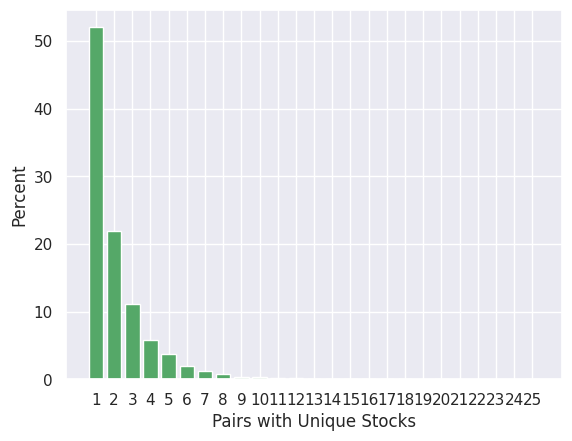

In [30]:
pairs_count_percent_s = round((pairs_count_df['count']/pairs_count_df['count'].sum()) * 100, 2)
plt.bar(pairs_count_df['pairs'], pairs_count_percent_s, color='g')
plt.xticks(range(1, pairs_count_df['pairs'].max()+1))
plt.xlabel('Pairs with Unique Stocks')
plt.ylabel('Percent')
plt.show()

In [31]:


def plot_dataframes(df_list: List[pd.DataFrame], colors: List[str], labels: List[str], x_label: str, y_label: str, title: str) -> None:
    ig, ax = plt.subplots(figsize=(10, 8))
    for ix, df in enumerate(df_list):
        color = colors[ix]
        label = labels[ix]
        ax.plot(df, color=color, label=label, linewidth=1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()


def day_profit_portfolio(all_transactions_df: pd.DataFrame, initial_holdings: float) -> pd.DataFrame:
    """
    Calculate the cumulative sum of the daily profit or loss. This sum is added to the initial
    holdings amount to show how the value would grow over time.

    :param all_transactions_df: a DataFrame with the daily data from the pairs trading simulation.
    :param initial_holdings: the initial investment
    :return: a DataFrame containing the time series showing the cumulative change from pairs trading.
    """
    day_profit_s = all_transactions_df['day_profit']
    profit_cumsum = np.cumsum(day_profit_s)
    portfolio_df = pd.DataFrame(initial_holdings + profit_cumsum)
    transaction_index = all_transactions_df['day_date']
    index = pd.to_datetime(transaction_index)
    portfolio_df.index = index
    portfolio_df.columns = ['Portfolio']
    return portfolio_df


def required_margin(all_transactions: pd.DataFrame) -> pd.DataFrame:
    """
    :param all_transactions: a DataFrame with the daily data from the pairs trading simulation.
    :return: the required margin for trading.
    """
    transaction_index = all_transactions_df['day_date']
    margin_df = pd.DataFrame(all_transactions_df['margin'].values)
    index = pd.to_datetime(transaction_index)
    margin_df.index = index
    margin_df.columns = ['Required Margin']
    return margin_df


def plot_holdings_vs_required_margin(all_transactions_df: pd.DataFrame, initial_holdings: float) -> None:
    """
    Plot the required margin vs. the current margin holdings. This starts with initial_holdings and changes
    with the pairs trading profit and loss.
    :param all_transactions_df: a DataFrame with the daily data from the pairs trading simulation.
    :param initial_holdings: the initial investment which is used for the margin.
    :return: None
    """
    portfolio_df = day_profit_portfolio(all_transactions_df, initial_holdings)
    margin_df = required_margin(all_transactions_df)
    plot_dataframes(df_list=[portfolio_df, margin_df],
                        colors=['red', 'blue'],
                        labels=['cash','Required Margin'],
                        x_label='Date',
                        y_label='Dollars',
                        title='Required Margin and Portfolio Balance')



<h2>
Opening Pairs Positions and Margin
</h2>
<p>
When the spread moves away from the running mean by 2σ a pair position is opened with long and short positions of approximately equal
dollar value (we are buying whole shares, so it may not be possible to have exactly equivalent positions).
</p>
<p>
There are 100 pairs, so 1/100 of the capital is allocated for the pair. If we have 100,000 in trading capital, 1,000 is allocated for each pair.
This supports a 2,000 short position and a 2,000 long position. The long position is used to partially meet the margin requirement for the short position.
When a short position is opened there must be 50% in liquid assets or cash for
the margin (this is required by the US SEC Regulation T). In this case, we have 1,000 for the 50% margin. When the short is opened, the stock
is borrowed and immediately sold. The proceeds of the short sale are used to open an equivalent 2,000-long position. The result is a
relatively market-neutral position with 2,000-short and 2,000 long in the stock pair.
</p>
<p>
Once the position is opened, the prices for the stocks in the pair move.  As the prices move, Regulation T requires a margin of at least 25% for the short
positions, in addition to a long position that balances 100% of the short position. In the worst case, if the short position goes up and
the long position goes down, additional margin could be required.
</p>
<p>
The pairs trading backtest estimates the required margin for open pairs positions.  In the backtest, which is using close prices instead
of intraday prices, the margin requirement never crosses the margin reserve composed of the long position plus the margin cash (or other
securities).
</p>
<p>
When a pairs trade results in a profit, this profit is added to the initial trading capital and is used to open future positions.
</p>


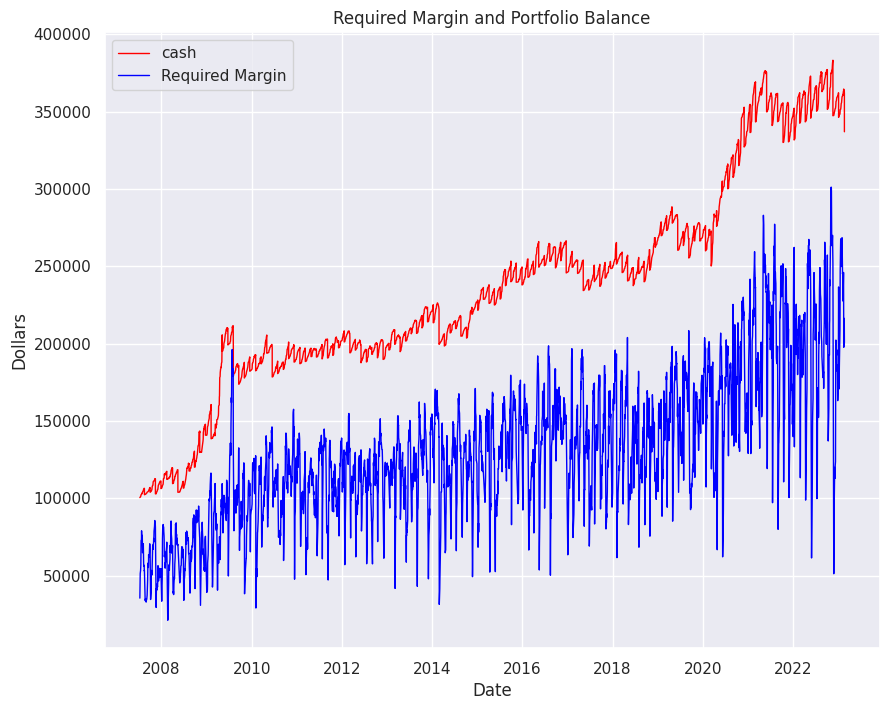

In [32]:


plot_holdings_vs_required_margin(all_transactions_df, initial_holdings=initial_holdings)


<p>
The plot above shows the required margin in excess of the long position in a pair. The current cash balance is also shown. This starts out with the
initial investment and grows as the pairs trading strategy yields profits.
</p>

In [33]:



def clip_distribution(dist_vals: pd.Series, sigma_lim: float) -> pd.Series:
    """
    Clip a distribution at mean +/-sigma_lim * sigma where sigma is the standard deviation.
    :param dist_vals:
    :param sigma_lim:
    :return: the clipped distribution
    """
    dist_mean = dist_vals.mean()
    dist_stddev = dist_vals.std()
    filter = list(
        map(lambda val: val >= dist_mean - (sigma_lim * dist_stddev) and val <= dist_mean + (sigma_lim * dist_stddev), dist_vals))
    filtered_vals = dist_vals[filter]
    return filtered_vals


def plot_return_distribution(all_transactions_df: pd.DataFrame, sigma_lim: float) -> None:
    """
    Plot the distribution of the daily returns from pairs trading.  The return distribution
    is the return for each day.
    :param all_transactions_df:
    :param sigma_lim:
    :return:
    """
    day_returns = all_transactions_df['day_return']
    filtered_returns = clip_distribution(day_returns, sigma_lim=sigma_lim)
    plt.hist(filtered_returns, bins='auto')
    plt.title('Distribution of Daily Pairs Return')
    plt.axvline(x=filtered_returns.mean(), color='red', linewidth=2)
    plt.show()


def plot_cash_distribution(all_transactions_df: pd.DataFrame, sigma_lim: float) -> None:
    """
    Plot the distribution of the daily profit and loss.
    :param all_transactions_df:
    :param sigma_lim:
    :return:
    """
    daily_cash = all_transactions_df['day_profit']
    filtered_daily_cash = clip_distribution(daily_cash, sigma_lim)
    plt.hist(filtered_daily_cash)
    plt.title('Daily Cash Distribution')
    plt.axvline(x=daily_cash.mean(), color='red', linewidth=2)
    plt.show()


def plot_hist(values_df: pd.DataFrame, x_label: str, y_label: str, title: str, add_mean: bool) -> None:
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.hist(values_df, bins='auto')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    if add_mean:
        plt.axvline(x=values_df.mean(), color='red', linewidth=2)
    plt.show()



<h2>
Distributions
</h2>
<p>
One way to check the reliability of backtest results is to look at the return statistics.
</p>
<p>
When a pairs trade is closed there will be a return for both the short and the long pairs positions. These pair positions make up a two-asset portfolio
where each asset (the long and short positions) are approximately 50 percent of the portfolio. Multiple pairs may be closed on a single day.
This forms a portfolio for the day. The returns for each pair can be added together as a weighted sum, where the weight is 1/num_pairs,
where num_pairs is the number of pairs that are closed on that day.
</p>
<p>
The return distribution is plotted below.
The return distribution looks like the return distributions that can be expected for stock market assets.
</p>


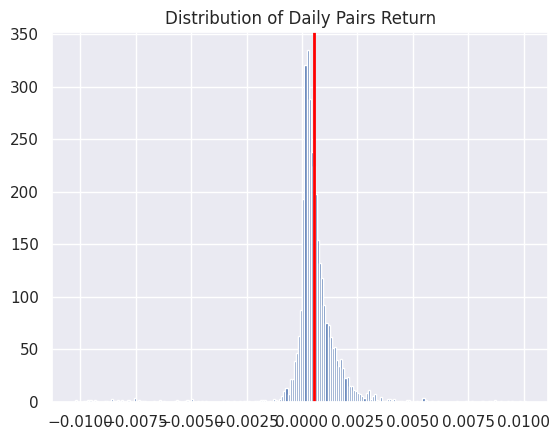

In [34]:


plot_return_distribution(all_transactions_df, sigma_lim=4)


<p>
When the pair is closed there will be a profit or loss. Calculating the portfolio value by adding the profit or loss for a day
is a simpler calculation than the return calculation.  The amount of cash (or loss) is per day plotted below.
</p>

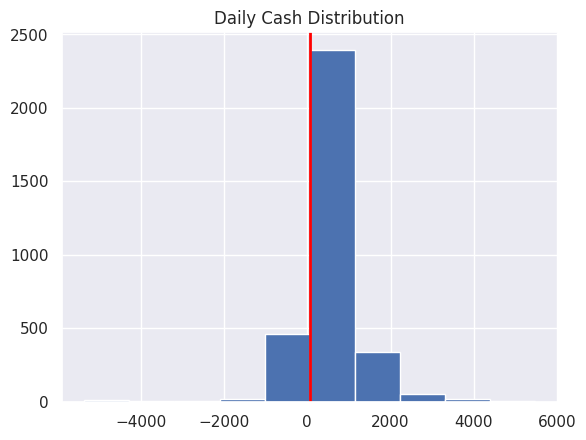

In [35]:


plot_cash_distribution(all_transactions_df, sigma_lim=2)

pairs_portfolio_df = day_profit_portfolio(all_transactions_df=all_transactions_df, initial_holdings=initial_holdings)

return_calculation = ReturnCalculation()
pairs_portfolio_return = return_calculation.calc_return_df(pairs_portfolio_df)


<p>
The previous statistics are from the daily trade information. The portfolio return can also be calculated from the running
portfolio value. This distribution is shown below. This distribution does not match the return distribution.
</p>

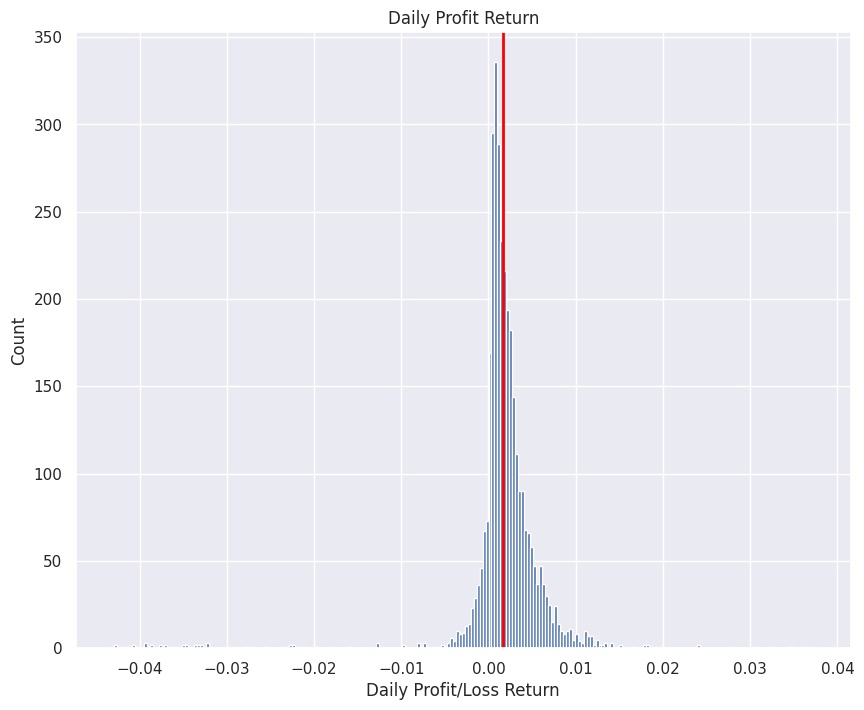

In [20]:



plot_hist(clip_distribution(pairs_portfolio_return.values, sigma_lim=4),
          x_label='Daily Profit/Loss Return',
          y_label='Count',
          title='Daily Profit Return',
          add_mean=True)



In [21]:


def plot_open_positions(all_transactions_df: pd.DataFrame) -> None:
    """
    Plot the number of open positions per day
    :param all_transactions_df:
    :return:
    """
    open_position_count_df = pd.DataFrame( all_transactions_df['num_open_positions'])
    open_position_count_df.index = pd.to_datetime(all_transactions_df['day_date'])
    open_position_count_df.columns = ['Open Positions']
    open_position_count_df.plot(grid=True, title='Open Positions', figsize=(10, 6))
    plt.show()


def plot_days_open(all_transactions_df: pd.DataFrame) -> None:
    """
    Plot the number of days a position is open.
    :param all_transactions_df:
    :return:
    """
    days_open_l = list(all_transactions_df['days_open'])
    # When the all_transactions_df DataFrame is built from the back test code it contains a list of lists
    # for the days_open: [[6, 3, 3], [5], [8, 6, 7], [10, 5, 10, 5, 2, 9]] When the DataFrame is read from
    # a file it contains a list of strings for the lists: ['[6, 3, 3]', '[5]', '[8, 6, 7]', '[10, 5, 10, 5, 2, 9]']
    # If it is a list of string, the string need to be converted to lists. This is done via the ast.literal_eval
    # function.
    if type(days_open_l[0]) == str:
        days_open_l = list(map(ast.literal_eval, days_open_l))
    days_open = list(deepflatten(days_open_l))
    plt.hist(days_open, bins='auto')
    plt.title('Number of days a pair trade is open')
    plt.xlabel('days')
    plt.show()


<h2>
Open Pairs Positions
</h2>
<p>
A long/short pair position is opened when the pair spread is 2σ above or below the running mean. When the spread crosses the mean, the pairs
position is closed. The plot below shows the number of days a pairs position is open.
</p>

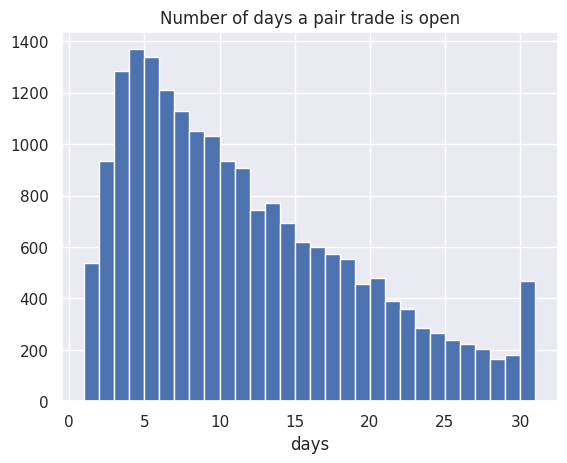

In [22]:


plot_days_open(all_transactions_df)


<p>
The plot below shows the distribution of the number of open pair positions per day. New pairs positions are not opened within 15 days of
the end of the quarter, since they would be unlike to be open long enough to mean revert and close.
</p>

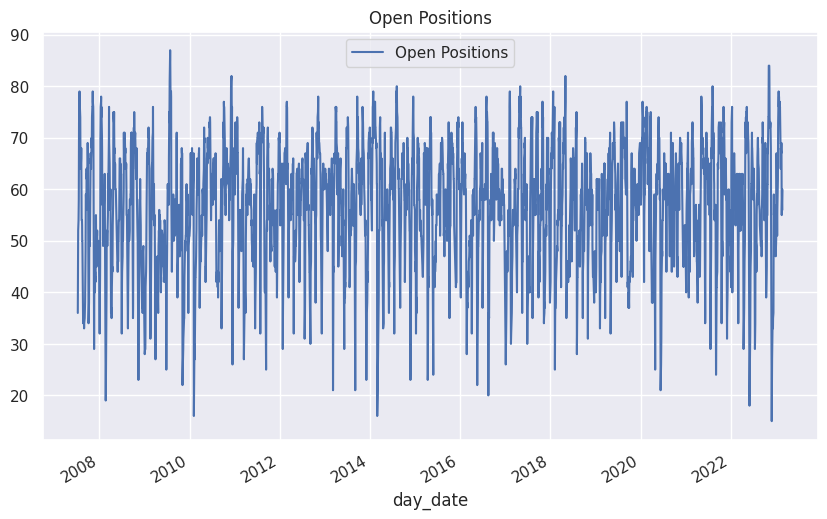

In [64]:


plot_open_positions(all_transactions_df)


<p>
At the start of the out-of-sample trading period, a new set of pairs is chosen using the past in-sample period. Pairs are opened
and closed as we move forward in time. Not all pairs positions
will mean revert and close by the end of the quarter. Any open pairs positions are closed at the end of the trading period.
</p>

total profit (loss): 236994.0 min val: -35870.0 max val: 12421.0


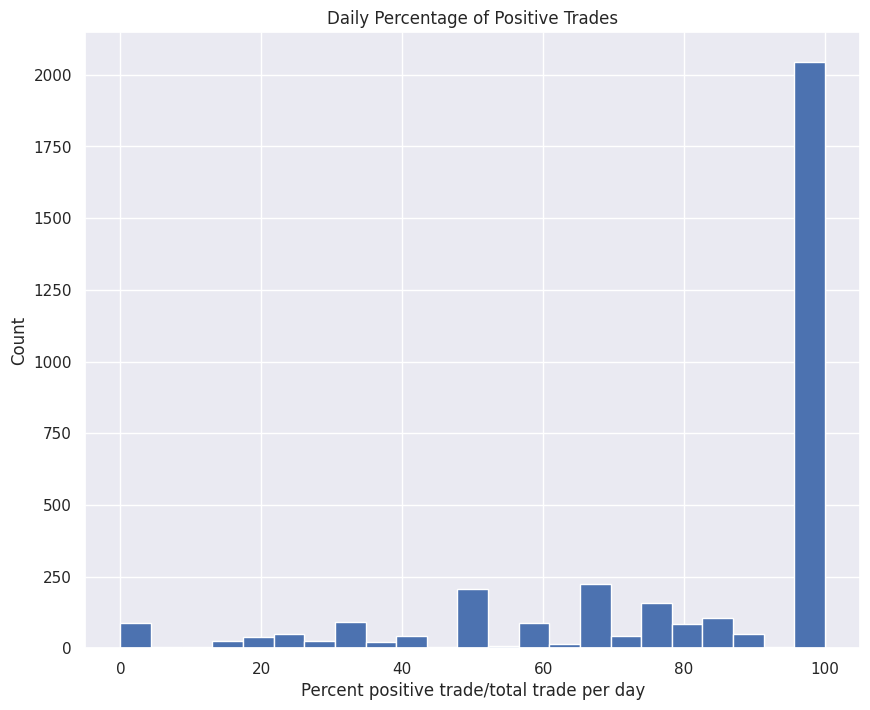

total percent positive trades: 58.83


In [65]:

cash_vals = all_transactions_df['day_profit']
print(f'total profit (loss): {round(sum(cash_vals),0)} min val: {round(min(cash_vals),0)} max val: {round(max(cash_vals),0)}')

positive_trades = all_transactions_df['positive_trades']
negative_trades = all_transactions_df['negative_trades']

total_trades = positive_trades + negative_trades
frac_positive = round((positive_trades / total_trades) * 100, 2)

plot_hist(frac_positive, x_label='Percent positive trade/total trade per day', y_label='Count', title='Daily Percentage of Positive Trades', add_mean=False)

print(f'total percent positive trades: {round((sum(positive_trades)/sum(total_trades)) * 100,2)}')


In [66]:




def spy_portfolio_period(spy_close_df: pd.DataFrame, start_date: datetime, end_date: datetime, initial_holdings: float) -> pd.DataFrame:
    """
    Calculate a portfolio based on SPY return, from start_date to end_date relative to an initial investment
    :param spy_close_df: The SPY close price time series.
    :param start_date: period start date
    :param end_date: period end date
    :param initial_holdings: the initial investment
    :return: a DataFrame containing the SPY time series relative to the initial investment.
    """
    spy_date_index = spy_close_df.index
    spy_start_ix = findDateIndex(spy_date_index, start_date)
    spy_end_ix = findDateIndex(spy_date_index, end_date)
    spy_close_period_df = spy_close_df.iloc[spy_start_ix:spy_end_ix + 1]
    return_calculation = ReturnCalculation()
    spy_return_df = return_calculation.calc_return_df(spy_close_period_df)
    spy_portfolio_df = pd.DataFrame(return_calculation.apply_return(initial_holdings, spy_return_df))
    spy_return_index = spy_return_df.index
    spy_return_start_date = pd.to_datetime(spy_return_index[0])
    spy_return_end_date = pd.to_datetime(spy_return_index[-1])
    spy_start_ix = findDateIndex(spy_date_index, spy_return_start_date)
    spy_end_ix = findDateIndex(spy_date_index, spy_return_end_date)
    spy_portfolio_df.index = pd.to_datetime(spy_date_index[spy_start_ix - 1:spy_end_ix + 1])
    spy_portfolio_df.columns = ['SPY']
    return spy_portfolio_df


def spy_portfolio(all_transactions_df: pd.DataFrame, spy_close_df: pd.DataFrame, initial_holdings: float) -> pd.DataFrame:
    """
    :param all_transactions_df:
    :param spy_close_df:
    :param initial_holdings:
    :return: a SPY portfolio relative to the time period in the pairs trading simulation and the initial investment.
    """
    transaction_dates = all_transactions_df['day_date']
    transaction_index = pd.to_datetime(transaction_dates.values)
    trans_first_date = transaction_index[0]
    trans_end_date = transaction_index[-1]
    spy_portfolio_df = spy_portfolio_period(spy_close_df=spy_close_df, start_date=trans_first_date, end_date=trans_end_date, initial_holdings=initial_holdings)
    return spy_portfolio_df


spy_portfolio_df = spy_portfolio(all_transactions_df=all_transactions_df, spy_close_df=spy_close_df, initial_holdings=initial_holdings)

random_portfolio_df = day_profit_portfolio(all_transactions_df=all_rand_transactions_df, initial_holdings=initial_holdings)


<h2>
Pairs Portfolio vs a Random Portfolio
</h2>
<p>
A portfolio of 100 random pairs is compared to the portfolio of pairs selected using correlation and cointegration. The random pairs are created
by selecting stocks from the industry sector stock universe. The random pairs are traded in the same way that the cointegrated pairs are traded
(e.g., the spread is calculated and trades are opened with the spread moves sufficiently away from the mean and closed with it return to the
mean).
</p>
<p>
By comparing the performance of pairs selected for mean reversion with random pairs we can get some measure of whether the statistical
tests yield better porfolio performance.
</p>

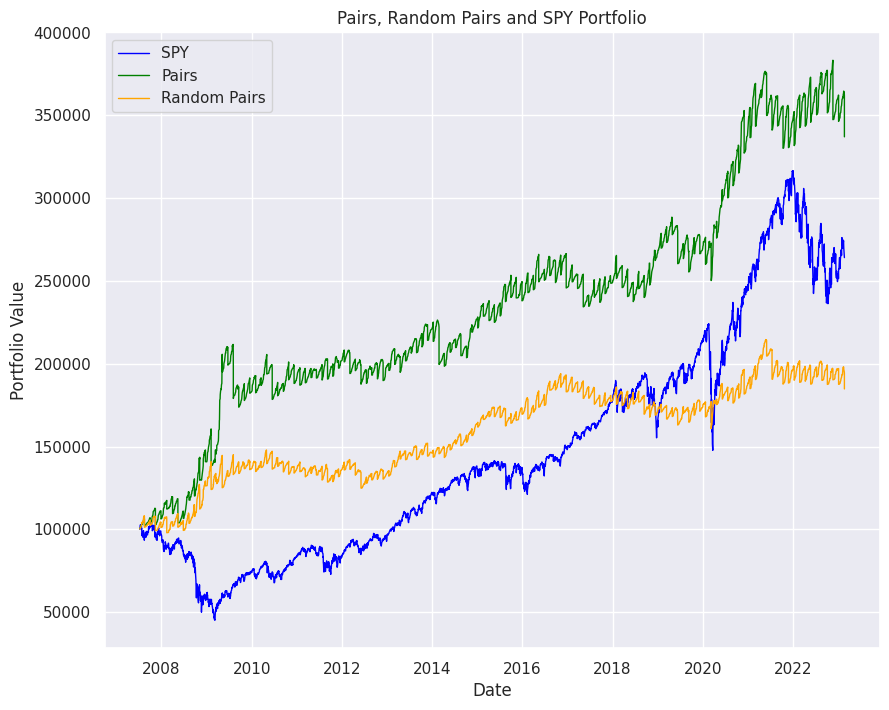

In [67]:


plot_dataframes(df_list=[spy_portfolio_df, pairs_portfolio_df, random_portfolio_df], colors=['blue', 'green', 'orange'],
                labels=['SPY', 'Pairs', 'Random Pairs'], x_label='Date', y_label='Portfolio Value',
                    title='Pairs, Random Pairs and SPY Portfolio')


<p>
This plot suggests that the application of correlation and cointegration delivers better returns than a randomly
selected set of pairs.
</p>

In [68]:


def return_slice(return_df: pd.DataFrame, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    return_index = return_df.index
    start_ix = findDateIndex(return_index, start_date)
    end_ix = findDateIndex(return_index, end_date)
    assert start_ix >= 0 and end_ix >= 0
    slice = return_df.iloc[start_ix:end_ix]
    return slice


def plot_period_return(spy_close_df: pd.DataFrame,
                       portfolio_profit_return: pd.DataFrame,
                       period_start: datetime,
                       period_end: datetime,
                       initial_holdings: float,
                       title: str) -> None:
    portfolio_return_period = return_slice(portfolio_profit_return, period_start, period_end)
    portfolio_return_index = portfolio_return_period.index
    spy_period = spy_portfolio_period(spy_close_df=spy_close_df,
                                      start_date=period_start,
                                      end_date=period_end,
                                      initial_holdings=initial_holdings)
    profit_portfolio_period = pd.DataFrame(
        return_calculation.apply_return(initial_holdings, portfolio_return_period))
    profit_index = portfolio_return_index.insert(0, portfolio_return_index[0] - timedelta(days=1))
    profit_portfolio_period.index = profit_index
    profit_portfolio_period.columns = ['Pairs Portfolio']

    plot_dataframes(df_list=[spy_period, profit_portfolio_period], colors=['orange', 'blue'], labels=['SPY', 'Pairs'],
                    x_label='Date', y_label='Dollars', title=title)


<h2>
Pairs Trading vs SPY: Five Years and One Year
</h2>
<p>
The plots below show the performance of the pairs trading strategy in the last five years and the last year.
</p>


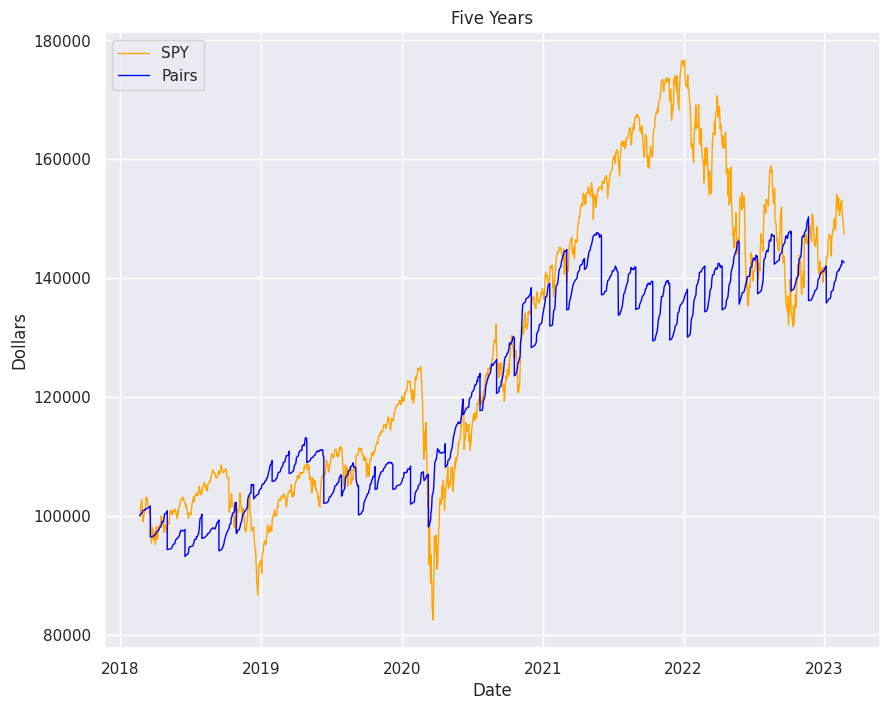

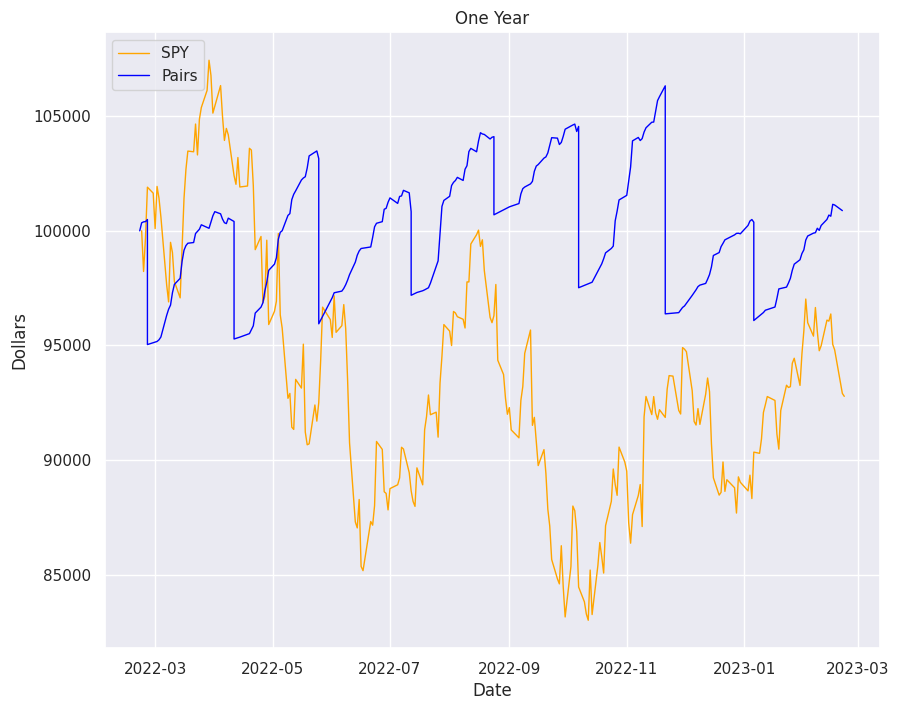

In [69]:



transaction_date_index = pd.to_datetime(all_transactions_df['day_date'])
trans_end_date = transaction_date_index.iloc[-1]
period_start = trans_end_date - relativedelta(years=5)

plot_period_return(spy_close_df=spy_close_df,
                   portfolio_profit_return=pairs_portfolio_return,
                   period_start=period_start,
                   period_end=trans_end_date,
                   initial_holdings=initial_holdings,
                   title='Five Years')

period_start = trans_end_date - relativedelta(years=1)

plot_period_return(spy_close_df=spy_close_df,
                   portfolio_profit_return=pairs_portfolio_return,
                   period_start=period_start,
                   period_end=trans_end_date,
                   initial_holdings=initial_holdings,
                   title='One Year')



<p>
The trading period for the strategy is half of a quarter (31 trading days). Before the start of the trading period, the next set of pairs is
selected using correlation and cointegration over a look-back period of 126 trading days (six months). Pairs trades are opened at the start
of the quarter as the pair spread sufficiently diverges from the mean. The pairs position is closed when the spread returns to the mean.
All open pairs positions are closed at the end of the quarter.
</p>
<p>
As the one-year plot shows, profits increase through the quarter. There is a drawdown at the end of the trading period when any open pairs positions are
closed. Presumably, the drawdown is a result of pairs that drifted together, resulting in a net loss when the pair is closed.
</p>
<p>
No new pairs positions are opened within 10 days of the end of the trading period (see the day_limit variable in the HistoricalBacktest class).
This limit was chosen because, in most cases, there would not be sufficient time for a pair to mean revert.
</p>
<p>
There may be additional algorithmic techniques to limit the losses in the unprofitable pairs. For example, if the pairs position crosses
a loss threshold, it might be closed to limit the loss.
</p>

In [70]:



def yearly_return(portfolio_df: pd.DataFrame) -> pd.DataFrame:
    first_row = True
    year_list = list()
    return_list = list()
    year_last_value = 0
    year_start_value = 0
    current_year = None
    for row_date, row_val in portfolio_df.iterrows():
        row_date = convert_date(row_date)
        row_val = row_val.values[0]
        if first_row:
            current_year = row_date.year
            year_start_value = row_val
            first_row = False
        elif row_date.year == current_year:
            year_last_value = row_val
        elif row_date.year != current_year:
            year_list.append(current_year)
            year_return = round(((year_last_value / year_start_value) - 1) * 100, 2)
            return_list.append(year_return)
            current_year = row_date.year
            year_start_value = row_val
    year_return_df = pd.DataFrame(return_list)
    year_return_df.index = year_list
    year_return_df.columns = portfolio_df.columns
    return year_return_df



portfolio_yearly_return_df = yearly_return(pairs_portfolio_df)
rand_yearly_return_df = yearly_return(random_portfolio_df)
spy_yearly_return_df = yearly_return(spy_portfolio_df)
portfolio_returns_df = pd.concat([portfolio_yearly_return_df, rand_yearly_return_df, spy_yearly_return_df], axis=1)
portfolio_returns_df.columns = ['Pairs', 'Random', 'SPY']

port_stats_df = pd.concat([pd.DataFrame(round(portfolio_returns_df.mean(), 2)), pd.DataFrame(round(portfolio_returns_df.median(), 2))], axis=1).transpose()
port_stats_df.index = ['Mean', 'Median']

portfolio_returns_df =  pd.concat([portfolio_returns_df, port_stats_df], axis=0)


In [71]:
#
# The code below will display in a Jupyter notebook. However, it will not display on a GitHub page so
# a simpler pandas table display is used. This is kept around for future reference since the code
# is so obscure.
#
# import plotly.offline as pyo
# import plotly.io as pio
# pio.renderers.default='notebook'
# pyo.init_notebook_mode()
# table = ff.create_table(portfolio_returns_df, index=True)
# table.update_layout(title_text='Yearly Returns (percent)', margin=dict(t=50))
# pyo.iplot(table)

<h2>
Discussion
</h2>
<h3>
Returns for Cointegrated and Random Pairs
</h3>


In [72]:


portfolio_returns_df.style.format(precision=2)


,Pairs,Random,SPY
2007,5.75,0.85,-3.12
2008,32.11,24.44,-37.74
2009,30.03,8.01,19.88
2010,4.03,-0.44,10.96
2011,4.72,-0.64,-1.22
2012,-1.86,-1.78,11.69
2013,11.06,8.94,26.45
2014,2.41,11.86,12.37
2015,4.77,3.42,-0.76
2016,3.12,7.89,11.20


<p>
The yearly returns (as a percentage) for the pairs portfolio, the random pairs portfolio, and SPY are shown above.  The yearly returns for the
cointegrated pairs are almost double the returns for the random pairs. The random pairs use a seeded random
number generator, so the random pairs selected will always be the same over multiple runs of the notebook.
</p>
<p>
These results suggest that a pairs trading strategy that uses correlation and cointegration to select pairs delievers
returns that are, on average, higher than a strategy that uses pairs constructed from randomly selected stocks. The pairs strategy also
has low yearly draw down. The worst performance, in 2012, was a loss of a little less than two percent.
</p>
<p>
The length of the trading period has a significant impact on the pairs trading results. For a one quarter out-of-sample trading
period, correlation and cointegration are no better at selecting pairs that will mean revert than randomly selected pairs.
The shorter half quarter trading period delievers returns that are almost double the returns of the random pairs.
</p>
<p>
There are many articles on the pairs trading strategy and it is covered in books like <i>Algorithmic Trading</i> by E.P. Chan and <i>Pairs Trading</i>
by Ganapathy Vidyamurthy. Although the articles and books cover the in-sample calculations for cointegration, very few examine the persistence
of this statistic. Very few references use backtests that closely resemble the actual trading of the strategy.
</p>
<p>
Correlation and cointegration seem to have a rapid decay between the in-sample and the out-of-sample trading period (see
<a href="https://github.com/IanLKaplan/pairs_trading/blob/master/pairs_trading.ipynb"><i>Exploratory Statistics of Pairs Trading</i></a>).
</p>
<p>
The pairs trading strategy is a market-neutral strategy and has a significantly lower maximum drawdown than the S&P 500. The pairs strategy
is trading lower draw downs for performance that lags the S&P 500 in some years.
</p>


<h2>
Disclaimer
</h2>
<p>
This notebook is not financial advice, investment advice, or tax advice.
The information in this notebook is for informational and recreational purposes only.
The investment products discussed (ETFs, mutual funds, etc.) are for illustrative purposes
only. This is not a recommendation to buy, sell, or otherwise transact in any of the
products mentioned. Do your own due diligence. Past performance does not guarantee
future returns.
</p>